In [ ]:
!pip install biopython tensorflow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 69.6 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import numpy as np
import pandas as pd
from collections import Counter
import itertools
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, Masking
from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import randint, loguniform, uniform
import random
from sklearn.model_selection import RandomizedSearchCV
from torch.utils.data import TensorDataset, DataLoader
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

In [ ]:
%cd /content/drive/MyDrive/Stanford/Junior_Year/ML_Tutorial/Protein_Classification
!ls

/content/drive/MyDrive/Stanford/Junior_Year/ML_Tutorial/Protein_Classification
 balanced_seq.csv						 Protein_Classification.ipynb
 extracted_features.csv						 Tutorial_Presentation.gslides
'Predicting Protein Attributes Using Machine Learning.gslides'	'UniProt Search Criterion.gdoc'


In [ ]:
# Read in data
data = pd.read_csv('balanced_seq.csv')

# Replace unknown amino acids with Alanine
def replace_unknown_amino_acids(sequence, replacement='A'):
    return sequence.replace('X', replacement)

# Apply the function to your DataFrame
data['CleanSequence'] = data['Sequence'].apply(replace_unknown_amino_acids)
print(data.head())

df = data[['Entry', 'ProteinClass']]
df_all = data[['Entry', 'ProteinClass']]
df_NN = data[['Entry', 'ProteinClass']]
df_RNN = data[['Entry', 'Sequence', 'ProteinClass']]

    Entry                                           Sequence Selected_PDB  \
0  P07151  MARSVTVIFLVLVSLAVVLAIQKTPQIQVYSRHPPENGKPNFLNCY...         1kjv   
1  P78325  MRGLGLWLLGAMMLPAIAPSRPWALMEQYEVVLPWRLPGPRVRRAL...         4dd8   
2  Q16819  MAWIRSTCILFFTLLFAHIAAVPIKYLPEENVHDADFGEQKDISEI...         7uaf   
3  Q92932  MGPPLPLLLLLLLLLPPRVLPAAPSSVPRGRQLPGRLGCLLEEGLC...         2qep   
4  Q3UV74  MLGQCTLLPVLAGLLSLESALSQLCTKDNVSTCQDCIRSGPSCAWC...         2iue   

  ProteinClass                                      CleanSequence  
0          MHC  MARSVTVIFLVLVSLAVVLAIQKTPQIQVYSRHPPENGKPNFLNCY...  
1     Protease  MRGLGLWLLGAMMLPAIAPSRPWALMEQYEVVLPWRLPGPRVRRAL...  
2     Protease  MAWIRSTCILFFTLLFAHIAAVPIKYLPEENVHDADFGEQKDISEI...  
3  Phosphatase  MGPPLPLLLLLLLLLPPRVLPAAPSSVPRGRQLPGRLGCLLEEGLC...  
4     Integrin  MLGQCTLLPVLAGLLSLESALSQLCTKDNVSTCQDCIRSGPSCAWC...  


In [ ]:
# Add Sequence Length
# Accuracies: 0.736, 0.236, 0.766

df.loc[:, 'SequenceLength'] = data['CleanSequence'].apply(len)
df_seq = pd.concat([df, data['CleanSequence'].apply(len)], axis=1)
df_NN.loc[:, 'SequenceLength'] = data['CleanSequence'].apply(len)
df_all.loc[:, 'SequenceLength'] = data['CleanSequence'].apply(len)
print(df.head())

    Entry ProteinClass  SequenceLength
0  P07151          MHC             119
1  P78325     Protease             824
2  Q16819     Protease             746
3  Q92932  Phosphatase            1015
4  Q3UV74     Integrin             738


<ipython-input-6-a3c59207232e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'SequenceLength'] = data['CleanSequence'].apply(len)
<ipython-input-6-a3c59207232e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NN.loc[:, 'SequenceLength'] = data['CleanSequence'].apply(len)
<ipython-input-6-a3c59207232e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [ ]:
# Amino Acid Frequencies
# Accuracies: 0.903, 0.743, 0.88

# List of standard amino acids
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')

def calculate_aac(sequence):
    analysed_seq = ProteinAnalysis(sequence)
    percent = analysed_seq.get_amino_acids_percent()
    return [percent.get(aa, 0) for aa in amino_acids]

# Calculate AAC for each sequence
df_aac = data['CleanSequence'].apply(calculate_aac)
aac_df = pd.DataFrame(df_aac.tolist(), columns=amino_acids)

# Concatenate AAC features to the main DataFrame
df = pd.concat([df, aac_df], axis=1)
df_freq = pd.concat([df, aac_df], axis=1)
df_all = pd.concat([df_all, aac_df], axis=1)
df_NN = pd.concat([df_NN, aac_df], axis=1)
print(df.head())


    Entry ProteinClass  SequenceLength         A         C         D  \
0  P07151          MHC             119  0.042017  0.016807  0.042017   
1  P78325     Protease             824  0.091019  0.053398  0.036408   
2  Q16819     Protease             746  0.048257  0.025469  0.069705   
3  Q92932  Phosphatase            1015  0.089655  0.013793  0.058128   
4  Q3UV74     Integrin             738  0.040650  0.073171  0.048780   

          E         F         G         H  ...         M         N         P  \
0  0.058824  0.050420  0.016807  0.033613  ...  0.025210  0.042017  0.075630   
1  0.054612  0.027913  0.095874  0.041262  ...  0.016990  0.030340  0.087379   
2  0.052279  0.053619  0.073727  0.029491  ...  0.017426  0.045576  0.041555   
3  0.072906  0.021675  0.070936  0.026601  ...  0.019704  0.023645  0.077833   
4  0.050136  0.033875  0.081301  0.018970  ...  0.016260  0.048780  0.039295   

          Q         R         S         T         V         W         Y  
0  0.042017 

In [ ]:
# All possible dipeptide frequencies
# Accuracies: 0.916, 0.93, 0.926

amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
dipeptides = [''.join(dp) for dp in itertools.product(amino_acids, repeat=2)]

def calculate_dipeptide_comp(sequence):
    dipeptide_counts = Counter([sequence[i:i+2] for i in range(len(sequence)-1)])
    total = sum(dipeptide_counts.values())
    return [dipeptide_counts.get(dp, 0) / total for dp in dipeptides]

# Calculate dipeptide composition
df_dipep = data['CleanSequence'].apply(calculate_dipeptide_comp)
dipeptide_df = pd.DataFrame(df_dipep.tolist(), columns=[dp for dp in dipeptides])

# Concatenate dipeptide features to the main DataFrame
df = pd.concat([df, dipeptide_df], axis=1)
df_dipep = pd.concat([df, dipeptide_df], axis=1)
df_all = pd.concat([df_all, dipeptide_df], axis=1)
df_NN = pd.concat([df_NN, dipeptide_df], axis=1)
print(df.head())

    Entry ProteinClass  SequenceLength         A         C         D  \
0  P07151          MHC             119  0.042017  0.016807  0.042017   
1  P78325     Protease             824  0.091019  0.053398  0.036408   
2  Q16819     Protease             746  0.048257  0.025469  0.069705   
3  Q92932  Phosphatase            1015  0.089655  0.013793  0.058128   
4  Q3UV74     Integrin             738  0.040650  0.073171  0.048780   

          E         F         G         H  ...        YM        YN        YP  \
0  0.058824  0.050420  0.016807  0.033613  ...  0.000000  0.000000  0.000000   
1  0.054612  0.027913  0.095874  0.041262  ...  0.000000  0.001215  0.001215   
2  0.052279  0.053619  0.073727  0.029491  ...  0.000000  0.002685  0.002685   
3  0.072906  0.021675  0.070936  0.026601  ...  0.000986  0.000000  0.000986   
4  0.050136  0.033875  0.081301  0.018970  ...  0.000000  0.000000  0.000000   

         YQ        YR        YS        YT        YV        YW        YY  
0  0.000000 

In [ ]:
# Reduced Amino Acid Alphabet

# Define amino acid groupings
groupings = {
    'Aliphatic': 'GAVLIPM',
    'Aromatic': 'FYW',
    'Polar_Uncharged': 'STCQN',
    'Positive_Charged': 'HKR',
    'Negative_Charged': 'DE',
}

def reduce_alphabet(sequence):
    reduced_sequence = ''
    for aa in sequence:
        for group, members in groupings.items():
            if aa in members:
                reduced_sequence += members[0]  # Use the first amino acid of the group
                break
        else:
            reduced_sequence += 'X'  # For amino acids not in any group
    return reduced_sequence

# Apply reduction
data['RedSequence'] = data['CleanSequence'].apply(reduce_alphabet)

# Calculate frequencies of each group
group_representatives = [members[0] for members in groupings.values()]

In [ ]:
# Reduced Amino Acid Alphabet Frequencies
# Accuracies: 0.856, 0.423, 0.856

def calculate_group_freq(sequence):
    count = Counter(sequence)
    total = sum(count.values())
    return [count.get(gr, 0) / total for gr in group_representatives]

group_freq = data['RedSequence'].apply(calculate_group_freq)
group_freq_df = pd.DataFrame(group_freq.tolist(), columns=group_representatives)

# Concatenate group frequency features to the main DataFrame
df_red_freq = pd.concat([df, group_freq_df], axis=1)
df_all = pd.concat([df_all, group_freq_df], axis=1)
df_NN = pd.concat([df, group_freq_df], axis=1)

print(df_all.head())

    Entry ProteinClass  SequenceLength         A         C         D  \
0  P07151          MHC             119  0.042017  0.016807  0.042017   
1  P78325     Protease             824  0.091019  0.053398  0.036408   
2  Q16819     Protease             746  0.048257  0.025469  0.069705   
3  Q92932  Phosphatase            1015  0.089655  0.013793  0.058128   
4  Q3UV74     Integrin             738  0.040650  0.073171  0.048780   

          E         F         G         H  ...        YM        YN        YP  \
0  0.058824  0.050420  0.016807  0.033613  ...  0.000000  0.000000  0.000000   
1  0.054612  0.027913  0.095874  0.041262  ...  0.000000  0.001215  0.001215   
2  0.052279  0.053619  0.073727  0.029491  ...  0.000000  0.002685  0.002685   
3  0.072906  0.021675  0.070936  0.026601  ...  0.000986  0.000000  0.000986   
4  0.050136  0.033875  0.081301  0.018970  ...  0.000000  0.000000  0.000000   

         YQ        YR        YS        YT        YV        YW        YY  
0  0.000000 

In [ ]:
# N-Gram Profiles of Reduced Amino Acid Alphabet
# Accuracies 0.893, 0.713, 0.9

def generate_ngrams(group_representatives, n):
    return [''.join(ng) for ng in itertools.product(group_representatives, repeat=n)]

# Function to calculate n-gram frequencies
def calculate_ngram_freq(sequence, n, ngrams):
    ngram_counts = Counter([sequence[i:i+n] for i in range(len(sequence) - n + 1)])
    total = sum(ngram_counts.values())
    return [ngram_counts.get(ng, 0) / total for ng in ngrams]

# Compute and append n-gram frequencies for 2, 3, and 4 grams
for n in [2,3]:
    ngrams = generate_ngrams(group_representatives, n)
    gram_df = data['RedSequence'].apply(lambda x: calculate_ngram_freq(x, n, ngrams))
    gram_df = pd.DataFrame(gram_df.tolist(), columns=[f"{ng}" for ng in ngrams])
    df_red_ngram = pd.concat([df, gram_df], axis=1)
    df_all = pd.concat([df_all, gram_df], axis=1)
    df = pd.concat([df, gram_df], axis=1)
    df_NN = pd.concat([df_NN, gram_df], axis=1)

# Print the resulting DataFrame
print(df_all.head())

    Entry ProteinClass  SequenceLength         A         C         D  \
0  P07151          MHC             119  0.042017  0.016807  0.042017   
1  P78325     Protease             824  0.091019  0.053398  0.036408   
2  Q16819     Protease             746  0.048257  0.025469  0.069705   
3  Q92932  Phosphatase            1015  0.089655  0.013793  0.058128   
4  Q3UV74     Integrin             738  0.040650  0.073171  0.048780   

          E         F         G         H  ...       DHG       DHF       DHS  \
0  0.058824  0.050420  0.016807  0.033613  ...  0.000000  0.000000  0.000000   
1  0.054612  0.027913  0.095874  0.041262  ...  0.007299  0.002433  0.002433   
2  0.052279  0.053619  0.073727  0.029491  ...  0.006720  0.000000  0.006720   
3  0.072906  0.021675  0.070936  0.026601  ...  0.012833  0.000987  0.000987   
4  0.050136  0.033875  0.081301  0.018970  ...  0.002717  0.001359  0.002717   

        DHH       DHD       DDG       DDF       DDS       DDH       DDD  
0  0.000000 

In [ ]:
# Add Protein Properties Using BioPython
# Accuracies: 0.896, 0.56, 0.886

def calculate_physicochemical_props(sequence):
    analysis = ProteinAnalysis(sequence)

    flexibility = analysis.flexibility()
    avg_flexibility = sum(flexibility) / len(flexibility)

    helix, sheet, turn = analysis.secondary_structure_fraction()

    return {
        'MolecularWeight': analysis.molecular_weight(),
        'IsoelectricPoint': analysis.isoelectric_point(),
        'Aromaticity': analysis.aromaticity(),
        'InstabilityIndex': analysis.instability_index(),
        'Flexibility': avg_flexibility,
        'Helix': helix,
        'Sheet': sheet,
        'Turn': turn,
        'Gravy': analysis.gravy(),
    }

# Calculate physicochemical properties
df_props = data['CleanSequence'].apply(calculate_physicochemical_props).apply(pd.Series)

# Concatenate physicochemical features to the main DataFrame
df_prop = pd.concat([df, df_props], axis=1)
df_all = pd.concat([df_all, df_props], axis=1)

print(df_prop.head())

    Entry ProteinClass  SequenceLength         A         C         D  \
0  P07151          MHC             119  0.042017  0.016807  0.042017   
1  P78325     Protease             824  0.091019  0.053398  0.036408   
2  Q16819     Protease             746  0.048257  0.025469  0.069705   
3  Q92932  Phosphatase            1015  0.089655  0.013793  0.058128   
4  Q3UV74     Integrin             738  0.040650  0.073171  0.048780   

          E         F         G         H  ...       DDD  MolecularWeight  \
0  0.058824  0.050420  0.016807  0.033613  ...  0.000000       13719.7804   
1  0.054612  0.027913  0.095874  0.041262  ...  0.000000       88770.1778   
2  0.052279  0.053619  0.073727  0.029491  ...  0.001344       84417.9506   
3  0.072906  0.021675  0.070936  0.026601  ...  0.003949      111270.1076   
4  0.050136  0.033875  0.081301  0.018970  ...  0.000000       81545.8876   

   IsoelectricPoint  Aromaticity  InstabilityIndex  Flexibility     Helix  \
0          7.800046     0.1

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):

    y_pred = model.predict(X_test)

    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n=== {model_name} ===")
    print(f"Accuracy after tuning: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    classes = model.classes_
    conf_matrix = confusion_matrix(y_test, y_pred, labels=classes)
    plt.figure(figsize=(10,8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def run_models(df):
    # Define X and y
    y = df['ProteinClass']
    X = df.drop(['Entry', 'ProteinClass'], axis=1)
    print("Feature sample:")
    print(X.head())
    print("\nTarget sample:")
    print(y.head())

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Feature scaling (important for logistic regression and gradient boosting)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    ### Logistic Regression ###
    # Define the parameter distribution for 'C'
    param_dist_lr = {
        'C': loguniform(1e-3, 1e3),
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'multi_class': ['multinomial'],
        'max_iter': [500, 1000, 2000],
        'random_state': [42]
    }

    # Initialize Logistic Regression model
    lr_model = LogisticRegression()

    # Set up RandomizedSearchCV
    random_search_lr = RandomizedSearchCV(
        estimator=lr_model,
        param_distributions=param_dist_lr,
        n_iter=50,
        cv=5,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1
    )

    # Fit the RandomizedSearchCV to the training data
    random_search_lr.fit(X_train_scaled, y_train)

    # Get the best estimator
    best_lr_model = random_search_lr.best_estimator_
    print("Best parameters found for Logistic Regression:")
    print(random_search_lr.best_params_)

    # Evaluate Logistic Regression
    evaluate_model(best_lr_model, X_test_scaled, y_test, model_name="Logistic Regression")

    ### Random Forest Classifier ###
    # Define the parameter distribution
    param_dist_rf = {
        'n_estimators': randint(10, 1000),
        'max_depth': [None],
        'min_samples_split': randint(2, 5),
        'min_samples_leaf': randint(2, 5),
        'bootstrap': [True, False],
        'random_state': [42]
    }

    # Initialize Random Forest model
    rf_model = RandomForestClassifier()

    # Set up RandomizedSearchCV
    random_search_rf = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions=param_dist_rf,
        n_iter=50,
        cv=5,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1
    )

    # Fit the RandomizedSearchCV to the training data
    random_search_rf.fit(X_train, y_train)

    # Get the best estimator
    best_rf_model = random_search_rf.best_estimator_
    print("\nBest parameters found for Random Forest:")
    print(random_search_rf.best_params_)

    # Evaluate Random Forest
    evaluate_model(best_rf_model, X_test, y_test, model_name="Random Forest")

    ### Gradient Boosting Classifier ###
    # Initialize Gradient Boosting with hyperparameters
    gb_model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )

    # Train the model
    gb_model.fit(X_train_scaled, y_train)

    # Evaluate Gradient Boosting
    evaluate_model(gb_model, X_test_scaled, y_test, model_name="Gradient Boosting")


Feature sample:
   SequenceLength         A         C         D         E         F         G  \
0             119  0.042017  0.016807  0.042017  0.058824  0.050420  0.016807   
1             824  0.091019  0.053398  0.036408  0.054612  0.027913  0.095874   
2             746  0.048257  0.025469  0.069705  0.052279  0.053619  0.073727   
3            1015  0.089655  0.013793  0.058128  0.072906  0.021675  0.070936   
4             738  0.040650  0.073171  0.048780  0.050136  0.033875  0.081301   

          H         I         K  ...        YM        YN        YP        YQ  \
0  0.033613  0.067227  0.075630  ...  0.000000  0.000000  0.000000  0.000000   
1  0.041262  0.016990  0.029126  ...  0.000000  0.001215  0.001215  0.003645   
2  0.029491  0.067024  0.040214  ...  0.000000  0.002685  0.002685  0.002685   
3  0.026601  0.022660  0.036453  ...  0.000986  0.000000  0.000986  0.002959   
4  0.018970  0.042005  0.044715  ...  0.000000  0.000000  0.000000  0.004071   

         YR     

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters found for Logistic Regression:
{'C': 0.1767016940294795, 'max_iter': 500, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}

=== Logistic Regression ===
Accuracy after tuning: 0.9450
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.92      1.00      0.96        23
   Aquaporin       1.00      1.00      1.00        24
     Channel       0.88      0.79      0.83        19
        GPCR       0.89      1.00      0.94        17
    Integrin       0.94      1.00      0.97        17
         MHC       1.00      1.00      1.00        24
 Phosphatase       1.00      1.00      1.00        15
    Protease       1.00      0.95      0.98        22
         RTK       0.95      0.82      0.88        22
     Ser:Thr       0.83      0.88      0.86        17

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.95      0.94     

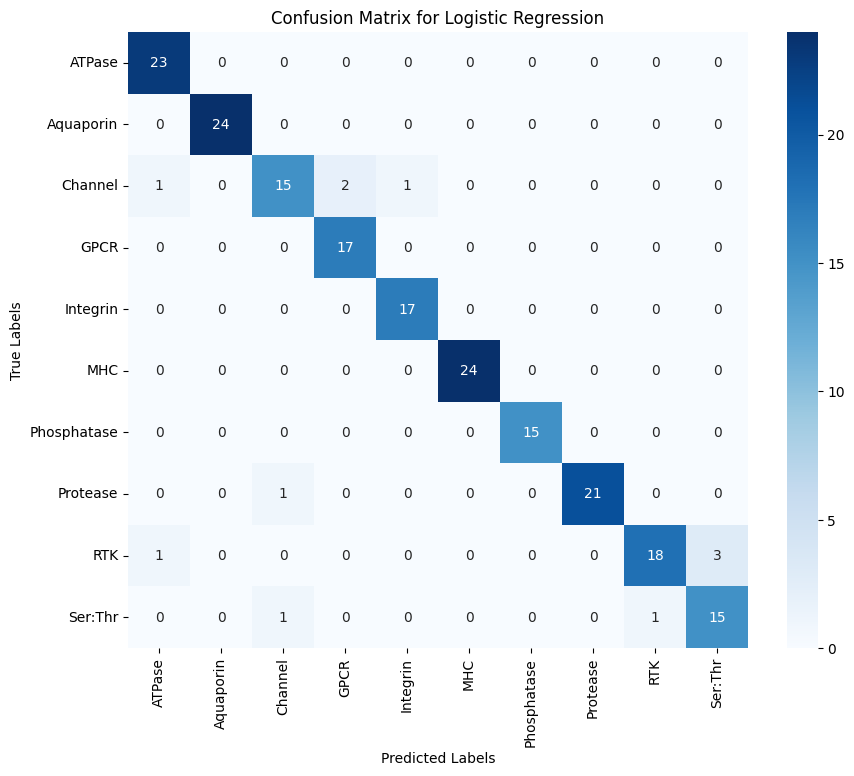


Best parameters found for Random Forest:
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 888, 'random_state': 42}

=== Random Forest ===
Accuracy after tuning: 0.9450
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.96      0.96      0.96        23
   Aquaporin       1.00      1.00      1.00        24
     Channel       0.81      0.89      0.85        19
        GPCR       1.00      1.00      1.00        17
    Integrin       1.00      1.00      1.00        17
         MHC       0.92      1.00      0.96        24
 Phosphatase       1.00      1.00      1.00        15
    Protease       1.00      0.91      0.95        22
         RTK       0.95      0.82      0.88        22
     Ser:Thr       0.83      0.88      0.86        17

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.94      0.95       2

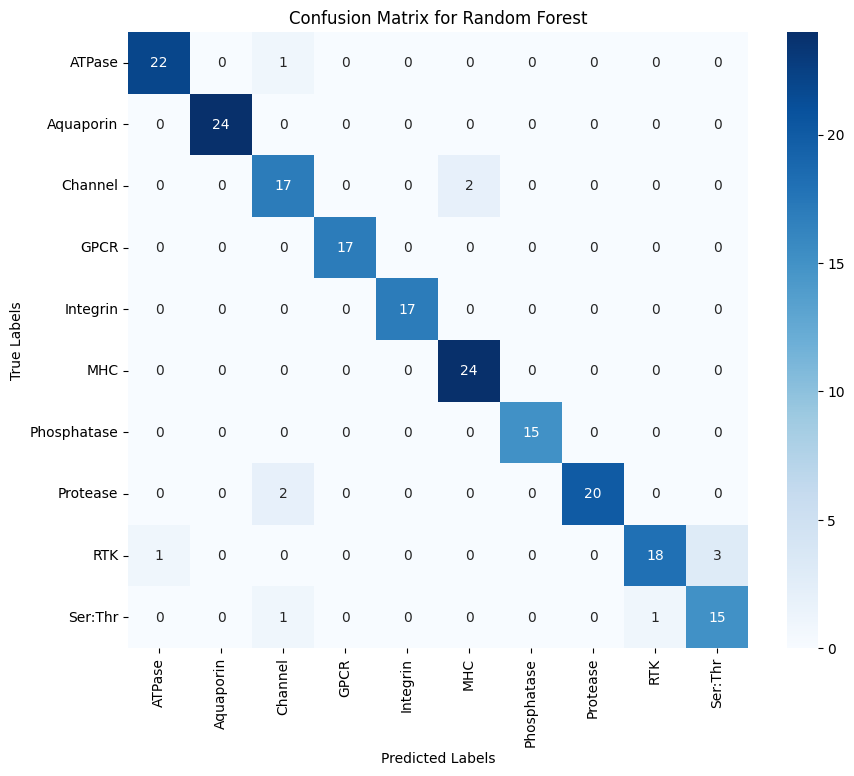


=== Gradient Boosting ===
Accuracy after tuning: 0.9450
Classification Report:
              precision    recall  f1-score   support

      ATPase       1.00      1.00      1.00        23
   Aquaporin       1.00      1.00      1.00        24
     Channel       0.89      0.89      0.89        19
        GPCR       1.00      1.00      1.00        17
    Integrin       1.00      1.00      1.00        17
         MHC       0.96      0.96      0.96        24
 Phosphatase       1.00      1.00      1.00        15
    Protease       0.90      0.86      0.88        22
         RTK       0.95      0.82      0.88        22
     Ser:Thr       0.76      0.94      0.84        17

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.94      0.95       200



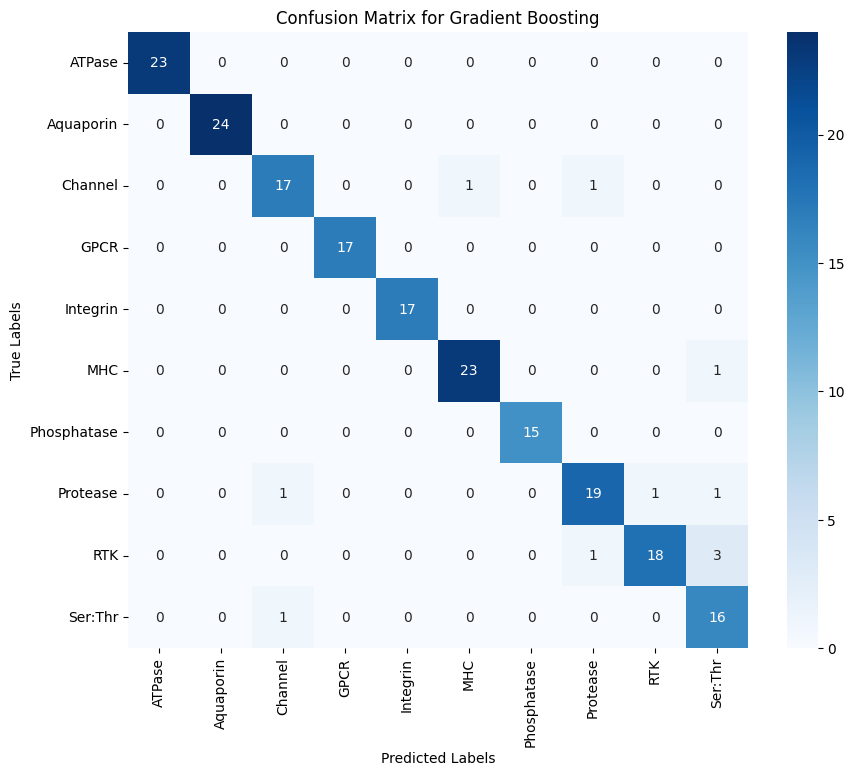

In [ ]:
run_models(df)

Feature sample:
   SequenceLength         A         C         D         E         F         G  \
0             119  0.042017  0.016807  0.042017  0.058824  0.050420  0.016807   
1             824  0.091019  0.053398  0.036408  0.054612  0.027913  0.095874   
2             746  0.048257  0.025469  0.069705  0.052279  0.053619  0.073727   
3            1015  0.089655  0.013793  0.058128  0.072906  0.021675  0.070936   
4             738  0.040650  0.073171  0.048780  0.050136  0.033875  0.081301   

          H         I         K  ...       DDD  MolecularWeight  \
0  0.033613  0.067227  0.075630  ...  0.000000       13719.7804   
1  0.041262  0.016990  0.029126  ...  0.000000       88770.1778   
2  0.029491  0.067024  0.040214  ...  0.001344       84417.9506   
3  0.026601  0.022660  0.036453  ...  0.003949      111270.1076   
4  0.018970  0.042005  0.044715  ...  0.000000       81545.8876   

   IsoelectricPoint  Aromaticity  InstabilityIndex  Flexibility     Helix  \
0          7.8000

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters found for Logistic Regression:
{'C': 0.008629132190071854, 'max_iter': 2000, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}

=== Logistic Regression ===
Accuracy after tuning: 0.9400
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.92      0.96      0.94        23
   Aquaporin       1.00      1.00      1.00        24
     Channel       0.94      0.79      0.86        19
        GPCR       0.89      1.00      0.94        17
    Integrin       1.00      1.00      1.00        17
         MHC       1.00      1.00      1.00        24
 Phosphatase       0.88      1.00      0.94        15
    Protease       1.00      0.95      0.98        22
         RTK       0.95      0.82      0.88        22
     Ser:Thr       0.79      0.88      0.83        17

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94  

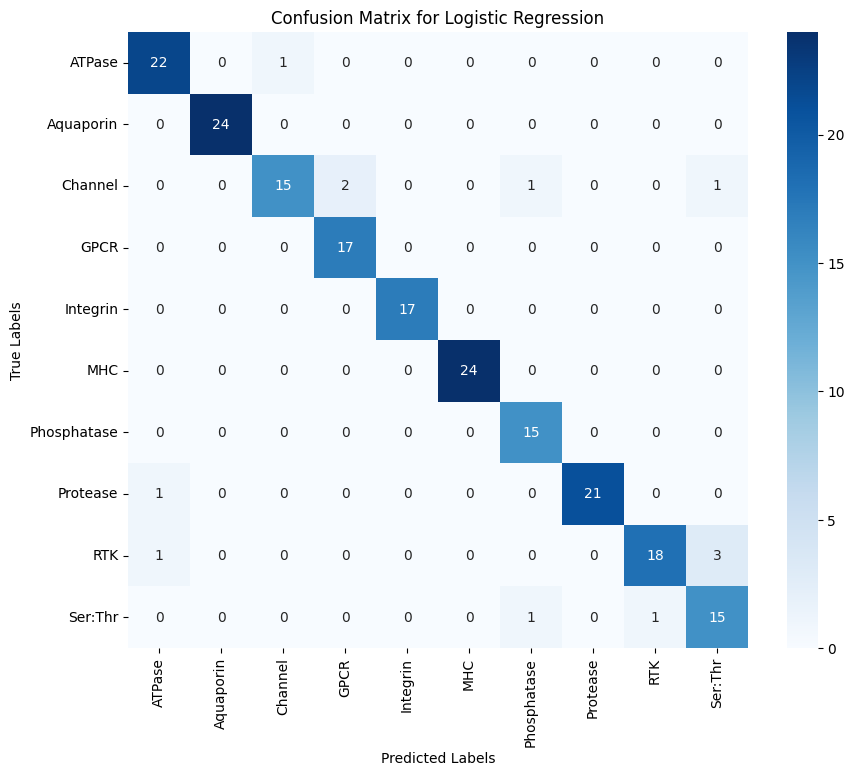


Best parameters found for Random Forest:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 166, 'random_state': 42}

=== Random Forest ===
Accuracy after tuning: 0.9250
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.96      0.96      0.96        23
   Aquaporin       1.00      1.00      1.00        24
     Channel       0.80      0.63      0.71        19
        GPCR       0.89      1.00      0.94        17
    Integrin       1.00      1.00      1.00        17
         MHC       0.92      1.00      0.96        24
 Phosphatase       1.00      1.00      1.00        15
    Protease       0.95      0.91      0.93        22
         RTK       0.83      0.86      0.84        22
     Ser:Thr       0.88      0.88      0.88        17

    accuracy                           0.93       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.93      0.92       

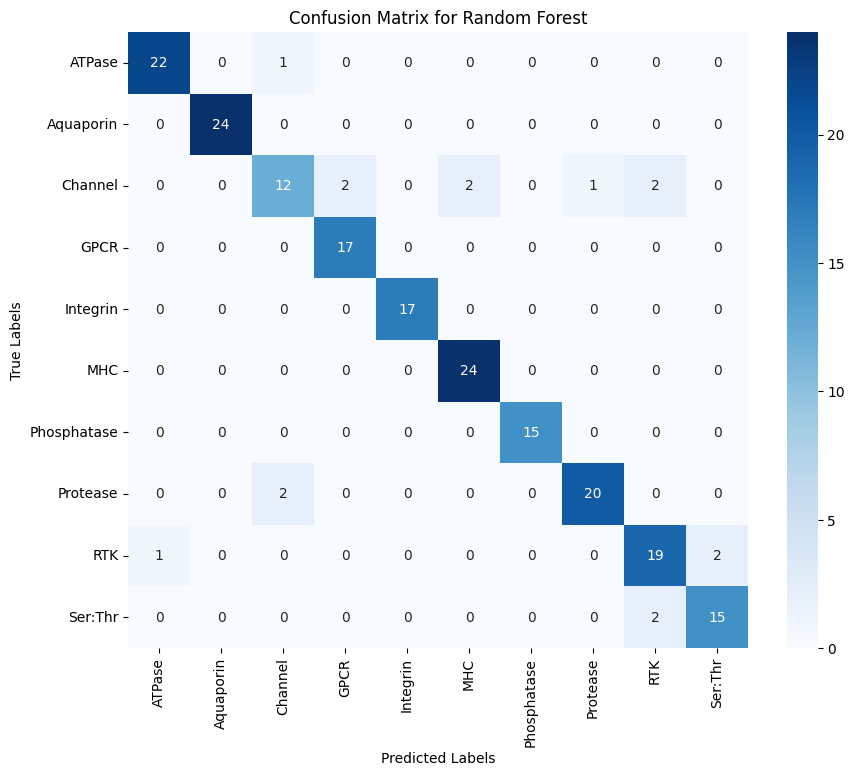


=== Gradient Boosting ===
Accuracy after tuning: 0.9200
Classification Report:
              precision    recall  f1-score   support

      ATPase       1.00      1.00      1.00        23
   Aquaporin       0.96      1.00      0.98        24
     Channel       0.93      0.74      0.82        19
        GPCR       1.00      1.00      1.00        17
    Integrin       1.00      1.00      1.00        17
         MHC       0.96      1.00      0.98        24
 Phosphatase       0.93      0.87      0.90        15
    Protease       0.83      0.86      0.84        22
         RTK       0.82      0.82      0.82        22
     Ser:Thr       0.79      0.88      0.83        17

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



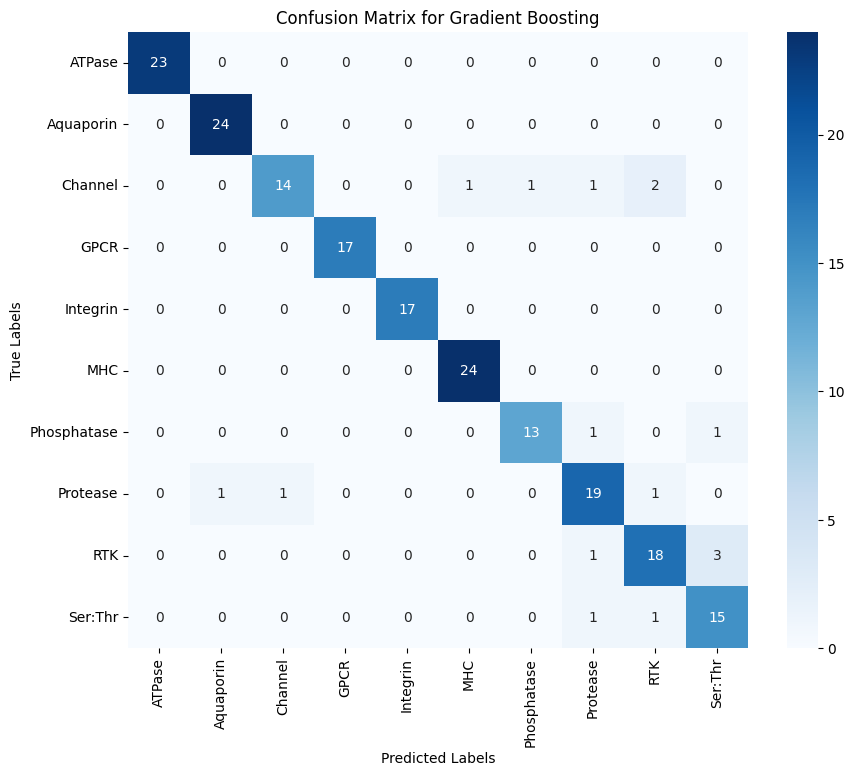

In [ ]:
run_models(df_all)

Feature sample:
   Sequence
0       119
1       824
2       746
3      1015
4       738

Target sample:
0            MHC
1       Protease
2       Protease
3    Phosphatase
4       Integrin
Name: ProteinClass, dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: 

Best parameters found for Logistic Regression:
{'C': 793.2047656808546, 'max_iter': 500, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}

=== Logistic Regression ===
Accuracy after tuning: 0.2800
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.41      0.39      0.40        23
   Aquaporin       0.48      0.58      0.53        24
     Channel       0.12      0.05      0.07        19
        GPCR       0.28      0.65      0.39        17
    Integrin       0.33      0.65      0.44        17
         MHC       0.34      0.42      0.38        24
 Phosphatase       0.00      0.00      0.00        15
    Protease       0.00      0.00      0.00        22
         RTK       0.00      0.00      0.00        22
     Ser:Thr       0.00      0.00      0.00        17

    accuracy                           0.28       200
   macro avg       0.20      0.27      0.22       200
weighted avg       0.21      0.28      

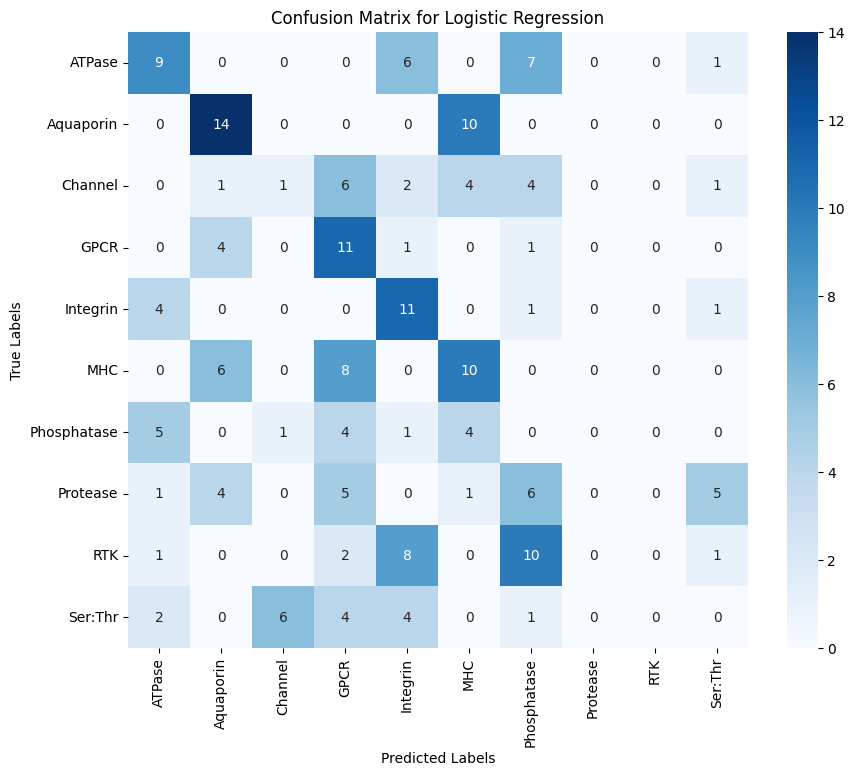


Best parameters found for Random Forest:
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 116, 'random_state': 42}

=== Random Forest ===
Accuracy after tuning: 0.7100
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.87      0.87      0.87        23
   Aquaporin       0.82      0.75      0.78        24
     Channel       0.47      0.37      0.41        19
        GPCR       0.47      0.47      0.47        17
    Integrin       0.89      1.00      0.94        17
         MHC       0.71      0.71      0.71        24
 Phosphatase       0.81      0.87      0.84        15
    Protease       0.61      0.77      0.68        22
         RTK       0.63      0.55      0.59        22
     Ser:Thr       0.76      0.76      0.76        17

    accuracy                           0.71       200
   macro avg       0.70      0.71      0.71       200
weighted avg       0.71      0.71      0.71       2

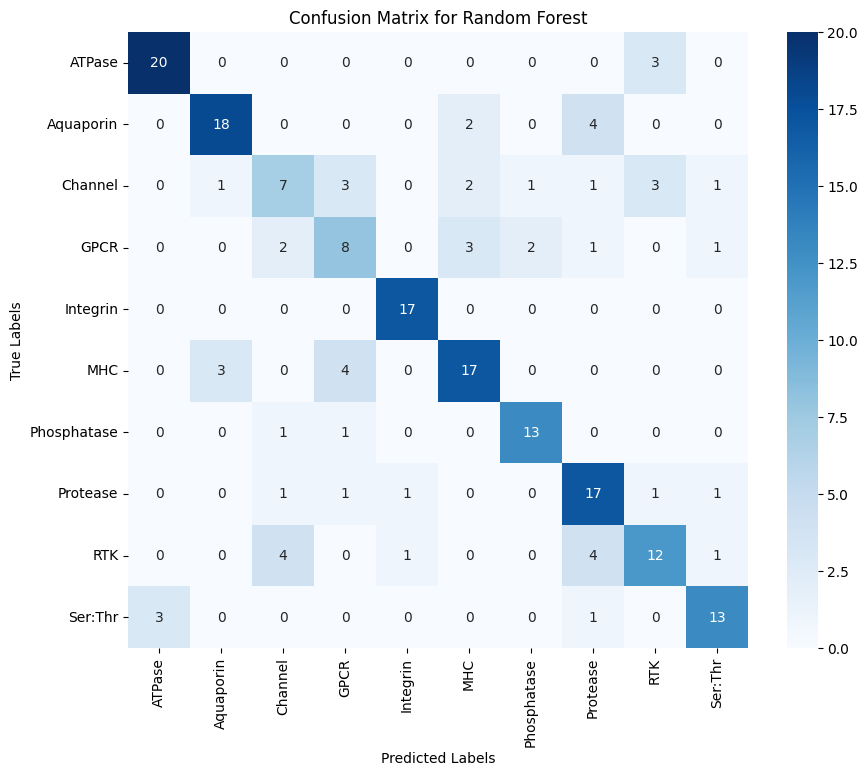


=== Gradient Boosting ===
Accuracy after tuning: 0.7900
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.96      0.96      0.96        23
   Aquaporin       0.81      0.92      0.86        24
     Channel       0.89      0.42      0.57        19
        GPCR       0.50      0.71      0.59        17
    Integrin       0.89      1.00      0.94        17
         MHC       0.69      0.75      0.72        24
 Phosphatase       1.00      0.80      0.89        15
    Protease       0.79      0.68      0.73        22
         RTK       0.74      0.77      0.76        22
     Ser:Thr       0.83      0.88      0.86        17

    accuracy                           0.79       200
   macro avg       0.81      0.79      0.79       200
weighted avg       0.81      0.79      0.79       200



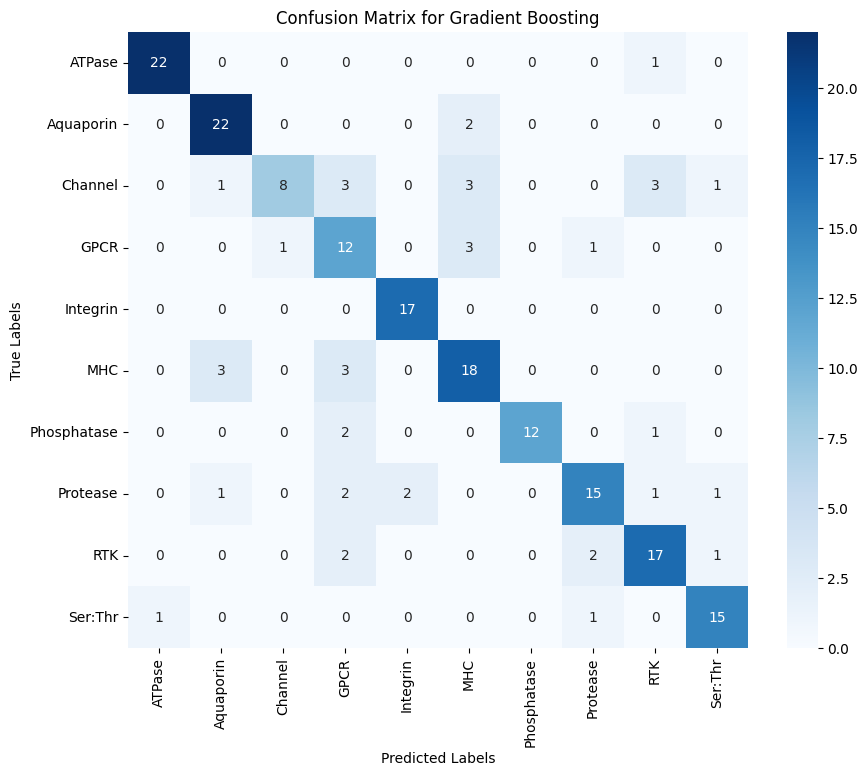

Feature sample:
          A         C         D         E         F         G         H  \
0  0.042017  0.016807  0.042017  0.058824  0.050420  0.016807  0.033613   
1  0.091019  0.053398  0.036408  0.054612  0.027913  0.095874  0.041262   
2  0.048257  0.025469  0.069705  0.052279  0.053619  0.073727  0.029491   
3  0.089655  0.013793  0.058128  0.072906  0.021675  0.070936  0.026601   
4  0.040650  0.073171  0.048780  0.050136  0.033875  0.081301  0.018970   

          I         K         L         M         N         P         Q  \
0  0.067227  0.075630  0.084034  0.025210  0.042017  0.075630  0.042017   
1  0.016990  0.029126  0.082524  0.016990  0.030340  0.087379  0.048544   
2  0.067024  0.040214  0.080429  0.017426  0.045576  0.041555  0.060322   
3  0.022660  0.036453  0.118227  0.019704  0.023645  0.077833  0.051232   
4  0.042005  0.044715  0.093496  0.016260  0.048780  0.039295  0.069106   

          R         S         T         V         W         Y  
0  0.033613  0.067

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters found for Logistic Regression:
{'C': 1.9066091638188458, 'max_iter': 1000, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}

=== Logistic Regression ===
Accuracy after tuning: 0.7600
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.85      0.96      0.90        23
   Aquaporin       1.00      1.00      1.00        24
     Channel       0.56      0.47      0.51        19
        GPCR       0.78      0.82      0.80        17
    Integrin       0.94      0.94      0.94        17
         MHC       0.80      0.83      0.82        24
 Phosphatase       0.75      0.80      0.77        15
    Protease       0.55      0.55      0.55        22
         RTK       0.62      0.59      0.60        22
     Ser:Thr       0.67      0.59      0.62        17

    accuracy                           0.76       200
   macro avg       0.75      0.76      0.75       200
weighted avg       0.75      0.76    

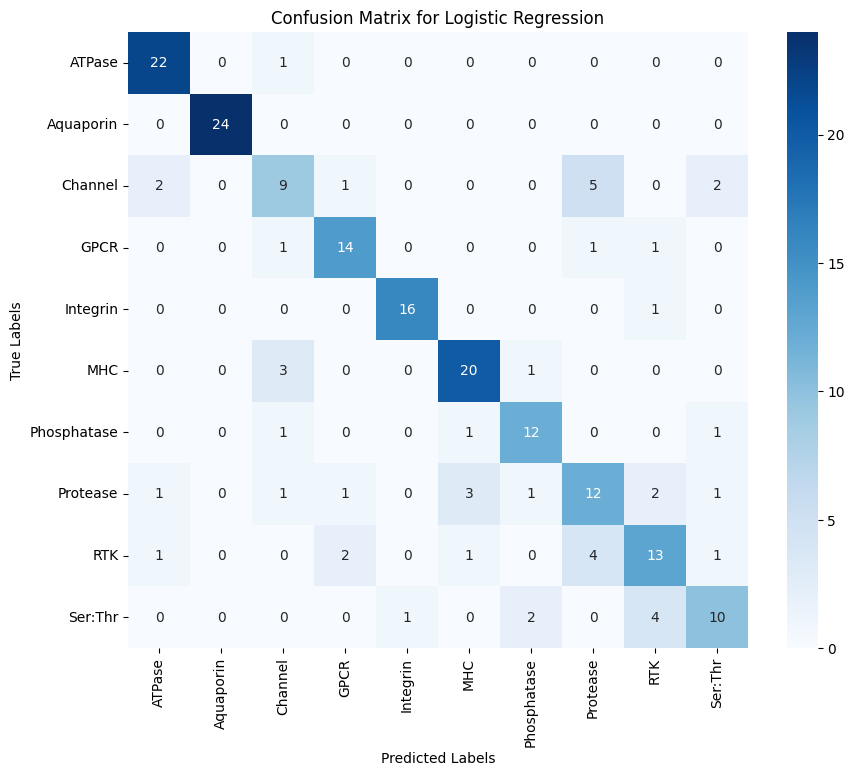


Best parameters found for Random Forest:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 584, 'random_state': 42}

=== Random Forest ===
Accuracy after tuning: 0.9350
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.88      0.96      0.92        23
   Aquaporin       1.00      1.00      1.00        24
     Channel       0.83      0.79      0.81        19
        GPCR       1.00      1.00      1.00        17
    Integrin       1.00      1.00      1.00        17
         MHC       1.00      1.00      1.00        24
 Phosphatase       1.00      1.00      1.00        15
    Protease       0.91      0.91      0.91        22
         RTK       0.95      0.82      0.88        22
     Ser:Thr       0.79      0.88      0.83        17

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       

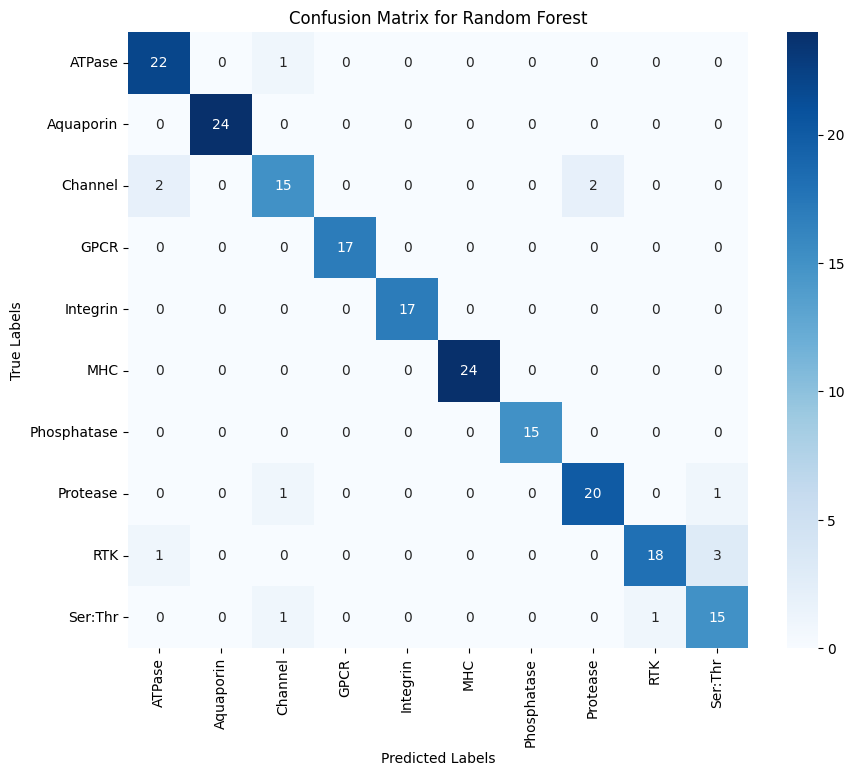


=== Gradient Boosting ===
Accuracy after tuning: 0.9150
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.92      1.00      0.96        23
   Aquaporin       1.00      1.00      1.00        24
     Channel       0.74      0.74      0.74        19
        GPCR       1.00      0.94      0.97        17
    Integrin       1.00      1.00      1.00        17
         MHC       1.00      0.88      0.93        24
 Phosphatase       0.94      1.00      0.97        15
    Protease       0.83      0.91      0.87        22
         RTK       0.90      0.82      0.86        22
     Ser:Thr       0.83      0.88      0.86        17

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.92       200



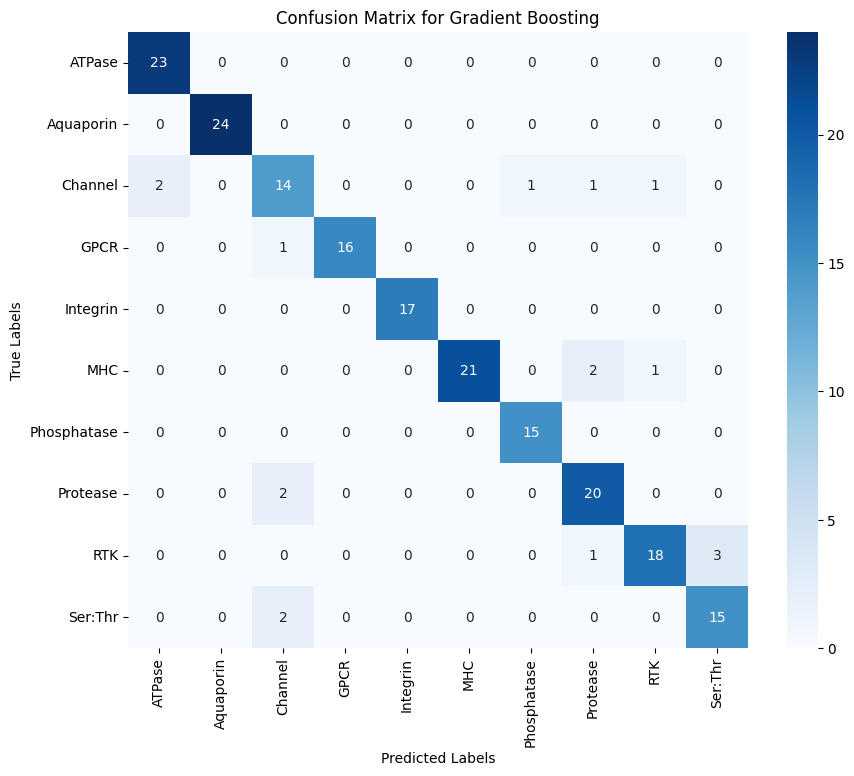

Feature sample:
         AA        AC        AD        AE        AF        AG        AH  \
0  0.000000  0.008475  0.000000  0.000000  0.000000  0.000000  0.008475   
1  0.009721  0.002430  0.001215  0.006075  0.002430  0.010936  0.002430   
2  0.004027  0.000000  0.002685  0.001342  0.004027  0.005369  0.004027   
3  0.009862  0.001972  0.004931  0.007890  0.001972  0.003945  0.000986   
4  0.002714  0.001357  0.001357  0.004071  0.000000  0.002714  0.000000   

         AI        AK        AL  ...        YM        YN        YP        YQ  \
0  0.008475  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
1  0.002430  0.002430  0.006075  ...  0.000000  0.001215  0.001215  0.003645   
2  0.008054  0.002685  0.004027  ...  0.000000  0.002685  0.002685  0.002685   
3  0.000986  0.001972  0.013807  ...  0.000986  0.000000  0.000986  0.002959   
4  0.002714  0.002714  0.004071  ...  0.000000  0.000000  0.000000  0.004071   

         YR        YS        YT        YV        YW 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters found for Logistic Regression:
{'C': 0.012606912518374074, 'max_iter': 500, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}

=== Logistic Regression ===
Accuracy after tuning: 0.9500
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.92      0.96      0.94        23
   Aquaporin       1.00      1.00      1.00        24
     Channel       0.94      0.84      0.89        19
        GPCR       0.94      1.00      0.97        17
    Integrin       1.00      1.00      1.00        17
         MHC       1.00      1.00      1.00        24
 Phosphatase       0.94      1.00      0.97        15
    Protease       0.96      1.00      0.98        22
         RTK       0.95      0.82      0.88        22
     Ser:Thr       0.83      0.88      0.86        17

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95   

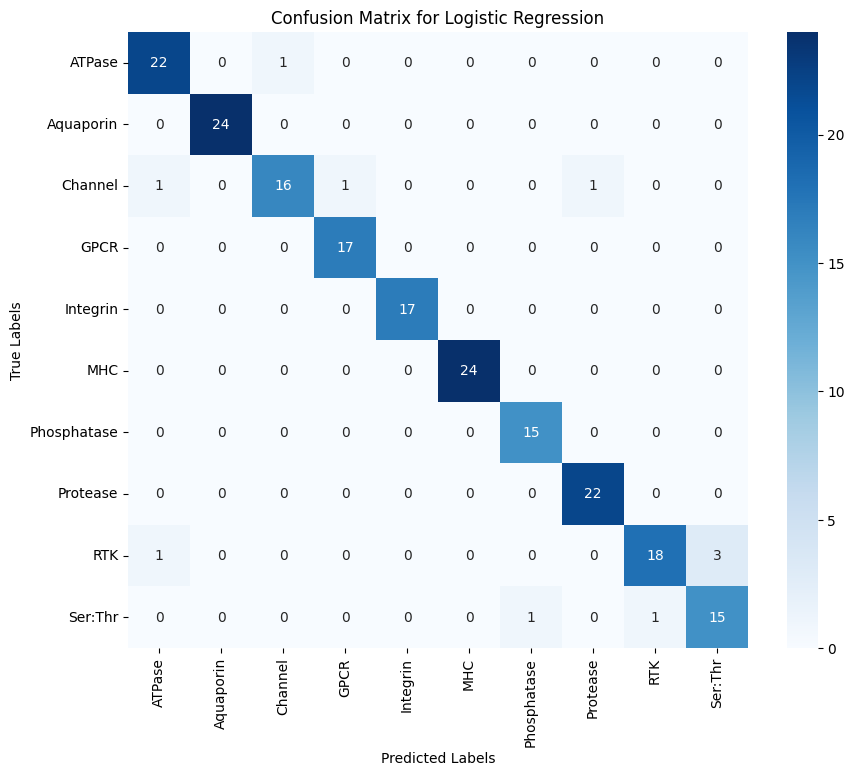


Best parameters found for Random Forest:
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 866, 'random_state': 42}

=== Random Forest ===
Accuracy after tuning: 0.9350
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.92      0.96      0.94        23
   Aquaporin       1.00      1.00      1.00        24
     Channel       0.84      0.84      0.84        19
        GPCR       0.94      1.00      0.97        17
    Integrin       1.00      1.00      1.00        17
         MHC       0.96      1.00      0.98        24
 Phosphatase       1.00      1.00      1.00        15
    Protease       1.00      0.86      0.93        22
         RTK       0.86      0.82      0.84        22
     Ser:Thr       0.83      0.88      0.86        17

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.93       2

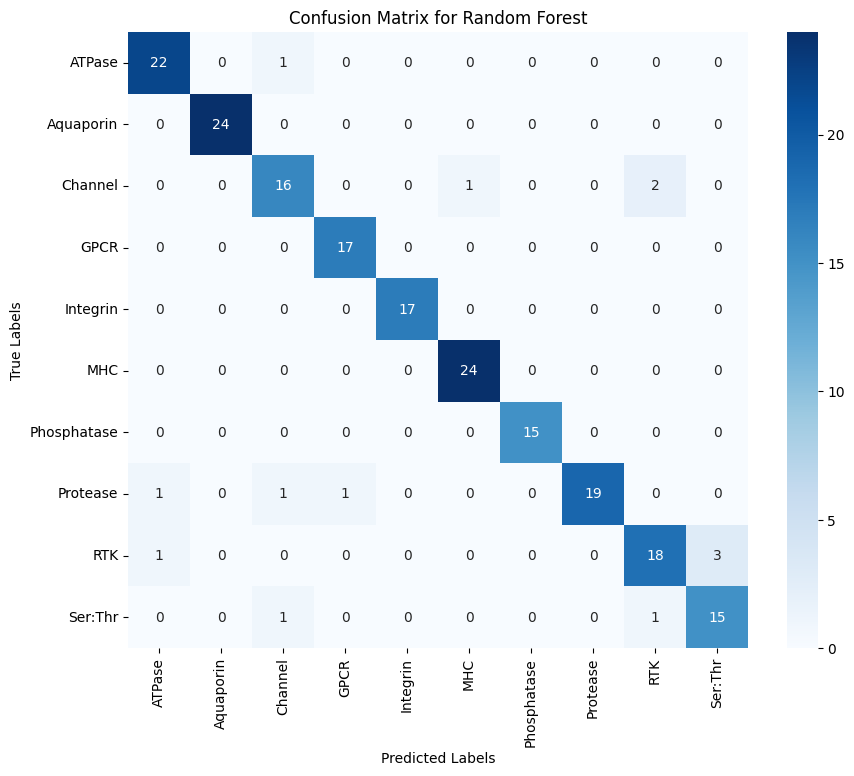


=== Gradient Boosting ===
Accuracy after tuning: 0.9150
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.96      0.96      0.96        23
   Aquaporin       1.00      1.00      1.00        24
     Channel       0.71      0.89      0.79        19
        GPCR       1.00      0.88      0.94        17
    Integrin       1.00      1.00      1.00        17
         MHC       1.00      0.96      0.98        24
 Phosphatase       0.93      0.93      0.93        15
    Protease       0.82      0.82      0.82        22
         RTK       0.95      0.82      0.88        22
     Ser:Thr       0.83      0.88      0.86        17

    accuracy                           0.92       200
   macro avg       0.92      0.91      0.92       200
weighted avg       0.92      0.92      0.92       200



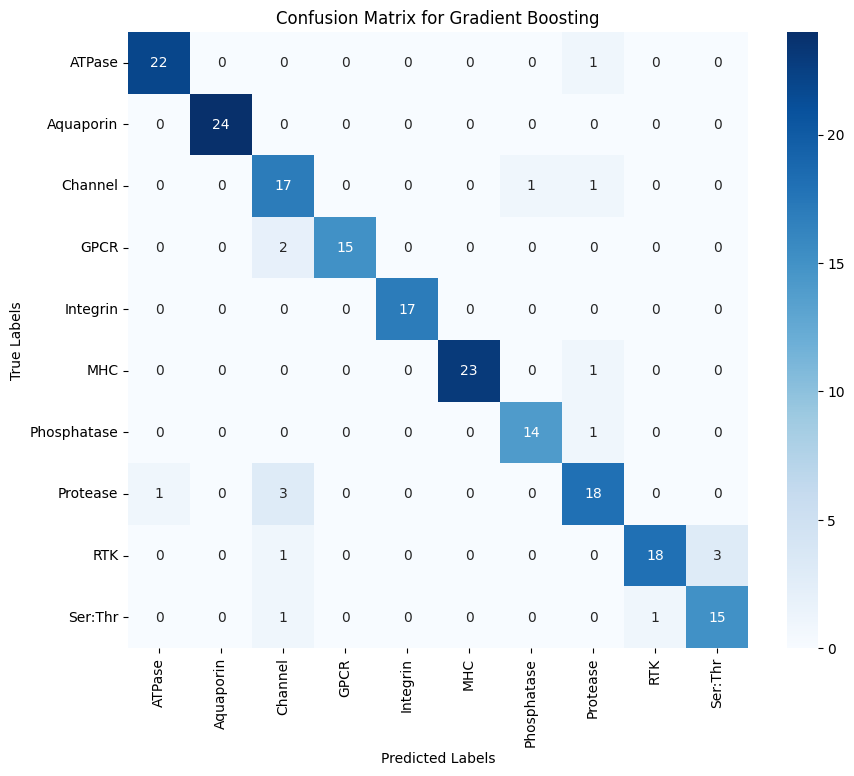

Feature sample:
          G         F         S         H         D
0  0.411765  0.100840  0.243697  0.142857  0.100840
1  0.474515  0.060680  0.239078  0.134709  0.091019
2  0.380697  0.105898  0.270777  0.120643  0.121984
3  0.459113  0.058128  0.220690  0.131034  0.131034
4  0.372629  0.071816  0.340108  0.116531  0.098916

Target sample:
0            MHC
1       Protease
2       Protease
3    Phosphatase
4       Integrin
Name: ProteinClass, dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters found for Logistic Regression:
{'C': 3.8115440886530614, 'max_iter': 1000, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}

=== Logistic Regression ===
Accuracy after tuning: 0.4100
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.38      0.43      0.41        23
   Aquaporin       0.80      1.00      0.89        24
     Channel       0.50      0.26      0.34        19
        GPCR       0.58      0.65      0.61        17
    Integrin       0.43      0.53      0.47        17
         MHC       0.46      0.46      0.46        24
 Phosphatase       0.27      0.53      0.36        15
    Protease       0.11      0.05      0.06        22
         RTK       0.18      0.09      0.12        22
     Ser:Thr       0.05      0.06      0.05        17

    accuracy                           0.41       200
   macro avg       0.38      0.41      0.38       200
weighted avg       0.38      0.41    

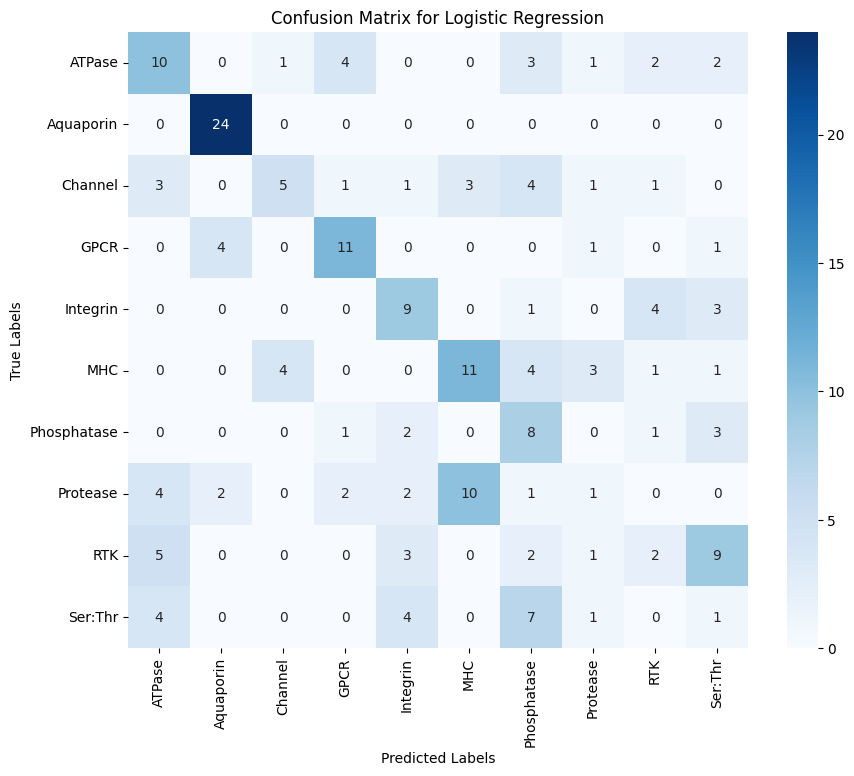


Best parameters found for Random Forest:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 584, 'random_state': 42}

=== Random Forest ===
Accuracy after tuning: 0.8600
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.82      0.78      0.80        23
   Aquaporin       0.96      1.00      0.98        24
     Channel       0.80      0.63      0.71        19
        GPCR       0.94      0.94      0.94        17
    Integrin       0.81      1.00      0.89        17
         MHC       0.90      0.79      0.84        24
 Phosphatase       0.74      0.93      0.82        15
    Protease       0.90      0.86      0.88        22
         RTK       0.89      0.73      0.80        22
     Ser:Thr       0.81      1.00      0.89        17

    accuracy                           0.86       200
   macro avg       0.86      0.87      0.86       200
weighted avg       0.86      0.86      0.86       

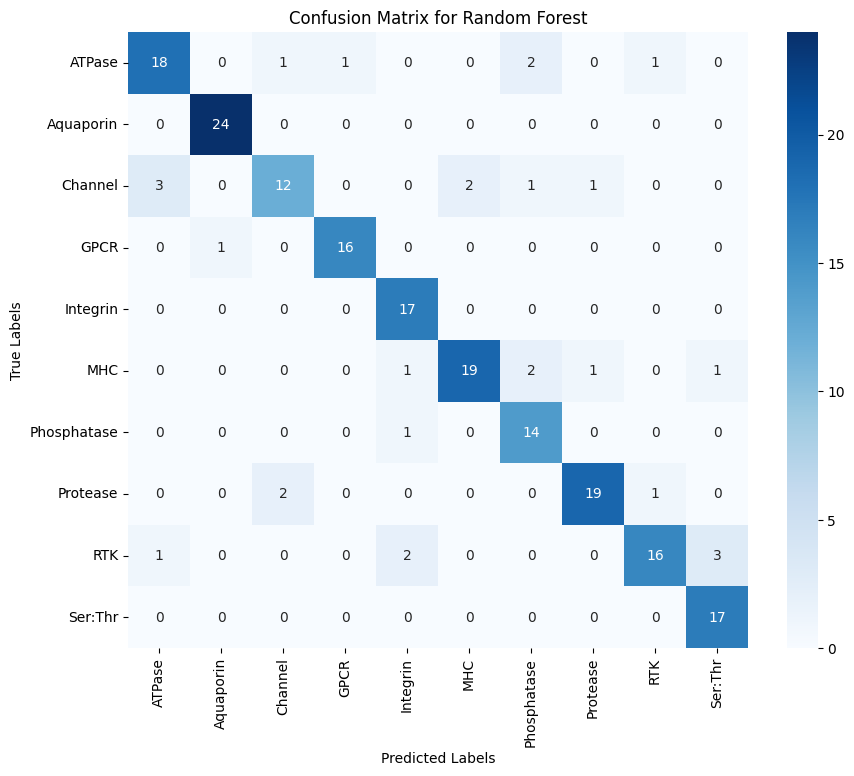


=== Gradient Boosting ===
Accuracy after tuning: 0.8650
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.69      0.78      0.73        23
   Aquaporin       0.96      1.00      0.98        24
     Channel       0.72      0.68      0.70        19
        GPCR       1.00      0.94      0.97        17
    Integrin       0.85      1.00      0.92        17
         MHC       1.00      0.83      0.91        24
 Phosphatase       0.74      0.93      0.82        15
    Protease       0.95      0.86      0.90        22
         RTK       0.89      0.73      0.80        22
     Ser:Thr       0.89      0.94      0.91        17

    accuracy                           0.86       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.86      0.87       200



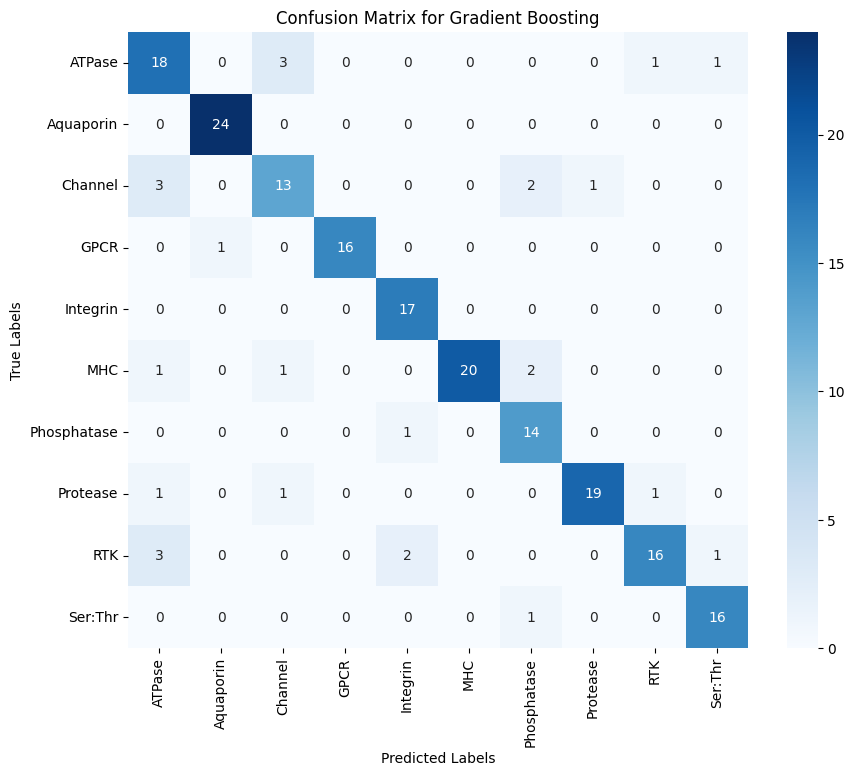

Feature sample:
        GGG       GGF       GGS       GGH       GGD       GFG       GFF  \
0  0.068376  0.008547  0.034188  0.025641  0.008547  0.017094  0.000000   
1  0.126521  0.014599  0.057178  0.025547  0.023114  0.012165  0.002433   
2  0.061828  0.024194  0.029570  0.010753  0.021505  0.018817  0.006720   
3  0.115499  0.007897  0.054294  0.028628  0.024679  0.007897  0.000000   
4  0.052989  0.016304  0.044837  0.019022  0.012228  0.013587  0.002717   

        GFS       GFH       GFD  ...       DHG       DHF       DHS       DHH  \
0  0.008547  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
1  0.009732  0.006083  0.001217  ...  0.007299  0.002433  0.002433  0.000000   
2  0.012097  0.004032  0.005376  ...  0.006720  0.000000  0.006720  0.000000   
3  0.005923  0.000987  0.001974  ...  0.012833  0.000987  0.000987  0.002962   
4  0.010870  0.002717  0.000000  ...  0.002717  0.001359  0.002717  0.001359   

        DHD       DDG       DDF       DDS       DDH 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters found for Logistic Regression:
{'C': 125.95965624516775, 'max_iter': 1000, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}

=== Logistic Regression ===
Accuracy after tuning: 0.8950
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.91      0.91      0.91        23
   Aquaporin       1.00      1.00      1.00        24
     Channel       0.85      0.58      0.69        19
        GPCR       0.80      0.94      0.86        17
    Integrin       0.94      1.00      0.97        17
         MHC       1.00      0.96      0.98        24
 Phosphatase       0.83      1.00      0.91        15
    Protease       0.90      0.86      0.88        22
         RTK       0.86      0.82      0.84        22
     Ser:Thr       0.79      0.88      0.83        17

    accuracy                           0.90       200
   macro avg       0.89      0.90      0.89       200
weighted avg       0.90      0.90    

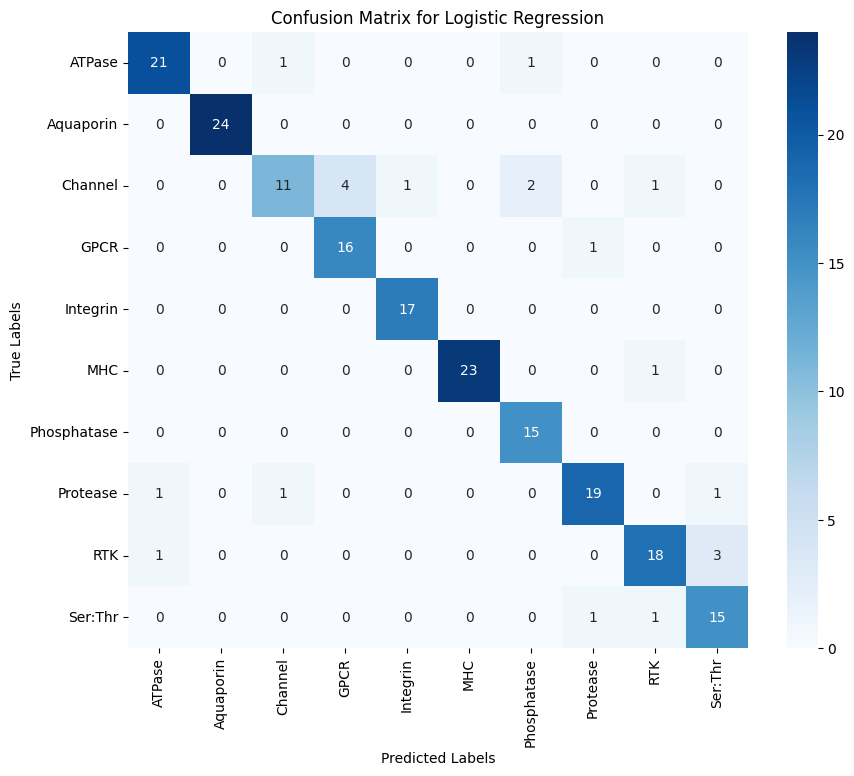


Best parameters found for Random Forest:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 584, 'random_state': 42}

=== Random Forest ===
Accuracy after tuning: 0.9150
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.85      0.96      0.90        23
   Aquaporin       0.96      1.00      0.98        24
     Channel       0.81      0.68      0.74        19
        GPCR       0.94      0.94      0.94        17
    Integrin       0.85      1.00      0.92        17
         MHC       0.92      1.00      0.96        24
 Phosphatase       1.00      0.93      0.97        15
    Protease       1.00      0.86      0.93        22
         RTK       0.90      0.86      0.88        22
     Ser:Thr       0.94      0.88      0.91        17

    accuracy                           0.92       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.92      0.92      0.91       

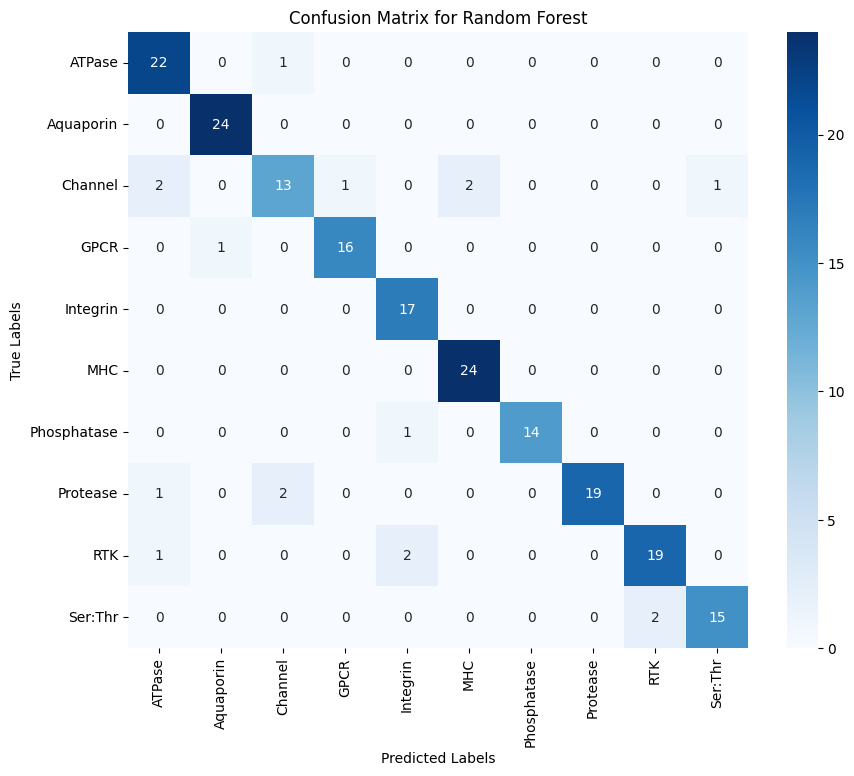


=== Gradient Boosting ===
Accuracy after tuning: 0.9050
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.92      0.96      0.94        23
   Aquaporin       1.00      1.00      1.00        24
     Channel       0.72      0.68      0.70        19
        GPCR       0.94      1.00      0.97        17
    Integrin       0.94      1.00      0.97        17
         MHC       0.96      0.92      0.94        24
 Phosphatase       0.78      0.93      0.85        15
    Protease       0.90      0.86      0.88        22
         RTK       0.90      0.82      0.86        22
     Ser:Thr       0.94      0.88      0.91        17

    accuracy                           0.91       200
   macro avg       0.90      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



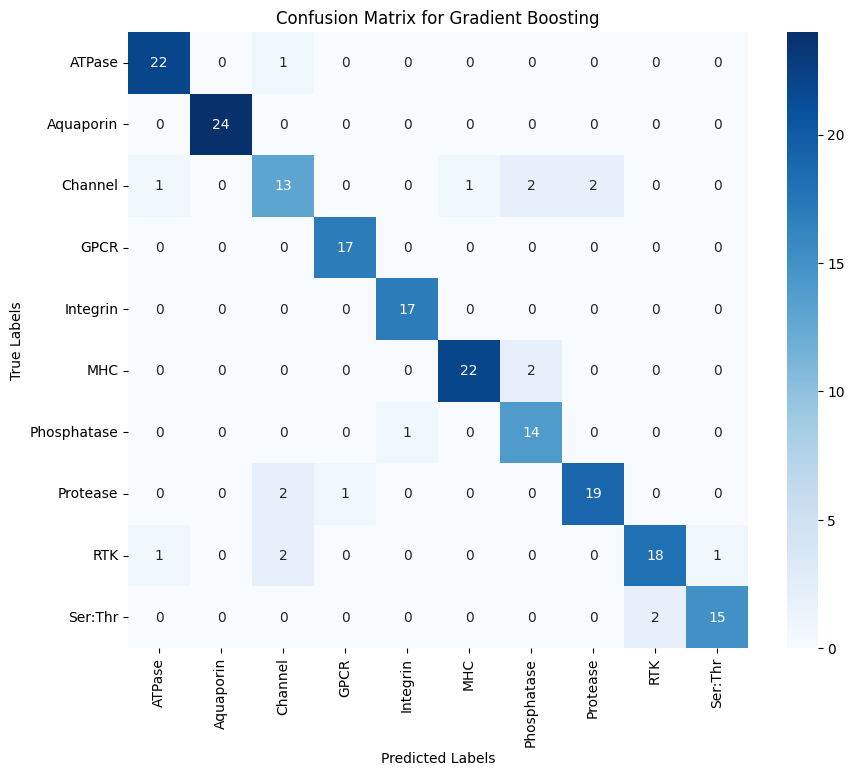

Feature sample:
   MolecularWeight  IsoelectricPoint  Aromaticity  InstabilityIndex  \
0       13719.7804          7.800046     0.100840         45.293361   
1       88770.1778          7.627986     0.060680         45.679988   
2       84417.9506          5.426271     0.105898         46.714397   
3      111270.1076          5.546713     0.058128         56.627901   
4       81545.8876          6.856397     0.071816         40.569241   

   Flexibility     Helix     Sheet      Turn     Gravy  
0     0.996506  0.285714  0.243697  0.428571 -0.142017  
1     0.997538  0.274272  0.310680  0.290049 -0.277913  
2     0.998364  0.238606  0.308311  0.367292 -0.379759  
3     1.005036  0.336946  0.321182  0.300493 -0.454483  
4     0.998124  0.245257  0.310298  0.323848 -0.310705  

Target sample:
0            MHC
1       Protease
2       Protease
3    Phosphatase
4       Integrin
Name: ProteinClass, dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters found for Logistic Regression:
{'C': 99.80894623678049, 'max_iter': 2000, 'multi_class': 'multinomial', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}

=== Logistic Regression ===
Accuracy after tuning: 0.7150
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.88      0.91      0.89        23
   Aquaporin       1.00      0.92      0.96        24
     Channel       0.62      0.53      0.57        19
        GPCR       0.68      0.88      0.77        17
    Integrin       0.69      0.65      0.67        17
         MHC       0.82      0.96      0.88        24
 Phosphatase       0.54      0.47      0.50        15
    Protease       0.62      0.45      0.53        22
         RTK       0.64      0.64      0.64        22
     Ser:Thr       0.48      0.59      0.53        17

    accuracy                           0.71       200
   macro avg       0.70      0.70      0.69       200
weighted avg       0.71      0.71     

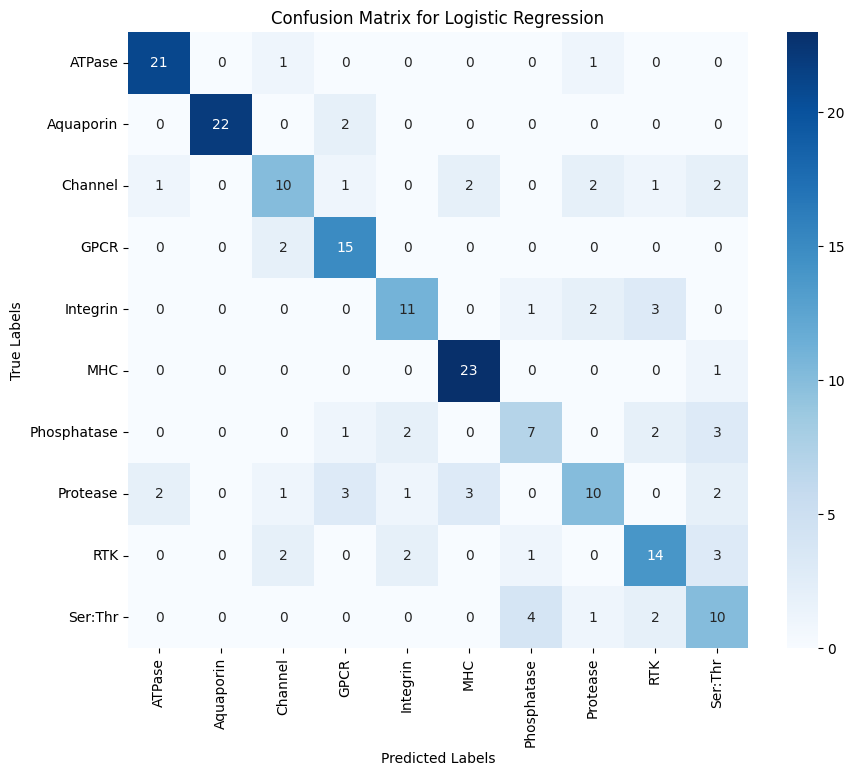


Best parameters found for Random Forest:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 305, 'random_state': 42}

=== Random Forest ===
Accuracy after tuning: 0.9350
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.96      0.96      0.96        23
   Aquaporin       1.00      1.00      1.00        24
     Channel       0.79      0.79      0.79        19
        GPCR       0.94      1.00      0.97        17
    Integrin       1.00      1.00      1.00        17
         MHC       0.92      1.00      0.96        24
 Phosphatase       0.88      1.00      0.94        15
    Protease       1.00      0.82      0.90        22
         RTK       0.95      0.86      0.90        22
     Ser:Thr       0.89      0.94      0.91        17

    accuracy                           0.94       200
   macro avg       0.93      0.94      0.93       200
weighted avg       0.94      0.94      0.93       

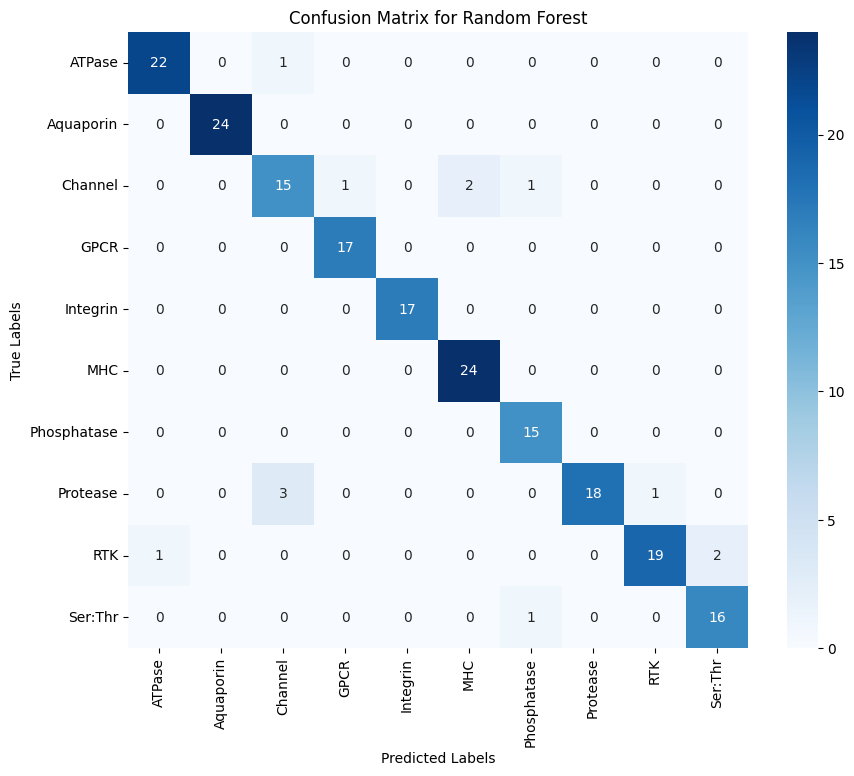


=== Gradient Boosting ===
Accuracy after tuning: 0.9300
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.96      0.96      0.96        23
   Aquaporin       1.00      1.00      1.00        24
     Channel       0.78      0.74      0.76        19
        GPCR       0.94      1.00      0.97        17
    Integrin       0.94      1.00      0.97        17
         MHC       0.92      1.00      0.96        24
 Phosphatase       1.00      1.00      1.00        15
    Protease       0.90      0.86      0.88        22
         RTK       1.00      0.82      0.90        22
     Ser:Thr       0.84      0.94      0.89        17

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



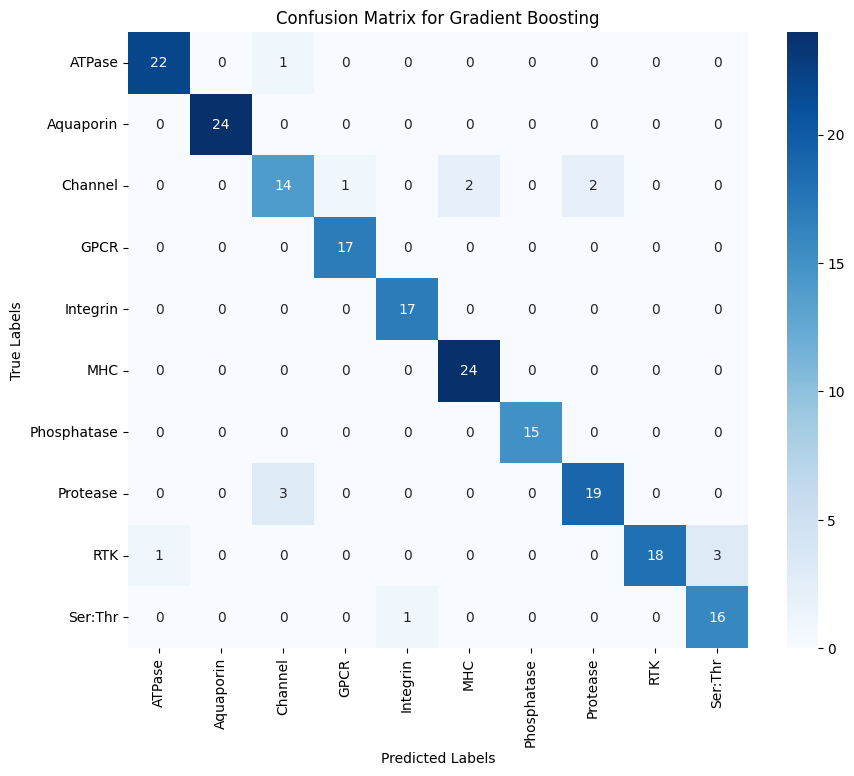

In [ ]:
datasets = [df_seq, df_freq, df_dipep, df_red_freq, df_red_ngram, df_prop]

for df in datasets:
    run_models(df)

In [ ]:
# Generate a new dataframe to train the neural network
# df_NN = data[['Entry', 'ProteinClass']]
print(df_NN.head())

    Entry ProteinClass  SequenceLength         G         F         S  \
0  P07151          MHC             119  0.411765  0.100840  0.243697   
1  P78325     Protease             824  0.474515  0.060680  0.239078   
2  Q16819     Protease             746  0.380697  0.105898  0.270777   
3  Q92932  Phosphatase            1015  0.459113  0.058128  0.220690   
4  Q3UV74     Integrin             738  0.372629  0.071816  0.340108   

          H         D        GG        GF  ...       DHG       DHF       DHS  \
0  0.142857  0.100840  0.144068  0.025424  ...  0.000000  0.000000  0.000000   
1  0.134709  0.091019  0.247874  0.031592  ...  0.007299  0.002433  0.002433   
2  0.120643  0.121984  0.147651  0.046980  ...  0.006720  0.000000  0.006720   
3  0.131034  0.131034  0.230769  0.016765  ...  0.012833  0.000987  0.000987   
4  0.116531  0.098916  0.145183  0.029851  ...  0.002717  0.001359  0.002717   

        DHH       DHD       DDG       DDF       DDS       DDH       DDD  
0  0.000000 

In [ ]:
# Split data
y_NN = df_NN['ProteinClass']
X_NN = df_NN.drop(['Entry', 'ProteinClass'], axis=1)
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X_NN.to_numpy(), y_NN.to_numpy(), test_size=0.2, stratify=y_NN, random_state=40)

print(X_train_NN.shape)
print(X_test_NN.shape)

# Create a label encoder
label_encoder = LabelEncoder()

# Fit the encoder on the training labels
label_encoder.fit(y_train_NN)

# Transform both training and testing labels
y_train_encoded = label_encoder.transform(y_train_NN)
y_test_encoded = label_encoder.transform(y_test_NN)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_NN, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_NN, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

(800, 156)
(200, 156)


In [ ]:
# Define neural network architecture
class ProteinClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ProteinClassifier, self).__init__()
        # Hidden layers
        self.fc_layers = nn.ModuleList()  # Use a ModuleList to store layers
        # self.dropout_layers = nn.ModuleList()
        for i in range(hidden_layers):
            self.fc_layers.append(nn.Linear(input_size if i == 0 else hidden_size, hidden_size)) # Input size changes after first layer
            # self.dropout_layers.append(nn.Dropout(p=0.10))
        # Output layer
        self.fc_out = nn.Linear(hidden_size, num_classes)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, out):
        # Pass through hidden layers using the ModuleList
        for i in range(hidden_layers):
            out = self.fc_layers[i](out)
            # out = self.dropout_layers[i](out)
            out = self.relu(out)
        # Output layer (no activation here because we'll use CrossEntropyLoss)
        out = self.fc_out(out)
        return out  # Return raw logits

input_size = 156
hidden_size = 175
num_classes = 10
hidden_layers = 5

model = ProteinClassifier(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005) # , weight_decay=1e-4

Epoch [1/75], Loss: 2.2888, Training Accuracy: 0.0912
Test Loss: 2.2548, Test Accuracy: 0.1000
Epoch [2/75], Loss: 2.2390, Training Accuracy: 0.0887
Test Loss: 2.2542, Test Accuracy: 0.1000
Epoch [3/75], Loss: 2.2398, Training Accuracy: 0.1113
Test Loss: 2.2475, Test Accuracy: 0.1000
Epoch [4/75], Loss: 2.2359, Training Accuracy: 0.0900
Test Loss: 2.2480, Test Accuracy: 0.1000
Epoch [5/75], Loss: 2.2328, Training Accuracy: 0.1025
Test Loss: 2.2288, Test Accuracy: 0.1000
Epoch [6/75], Loss: 2.2274, Training Accuracy: 0.0963
Test Loss: 2.2523, Test Accuracy: 0.1000
Epoch [7/75], Loss: 2.2225, Training Accuracy: 0.0950
Test Loss: 2.2316, Test Accuracy: 0.1000
Epoch [8/75], Loss: 2.2174, Training Accuracy: 0.1037
Test Loss: 2.2046, Test Accuracy: 0.1000
Epoch [9/75], Loss: 2.2137, Training Accuracy: 0.1025
Test Loss: 2.2369, Test Accuracy: 0.1000
Epoch [10/75], Loss: 2.2103, Training Accuracy: 0.1000
Test Loss: 2.2330, Test Accuracy: 0.1000
Epoch [11/75], Loss: 2.2080, Training Accuracy: 0

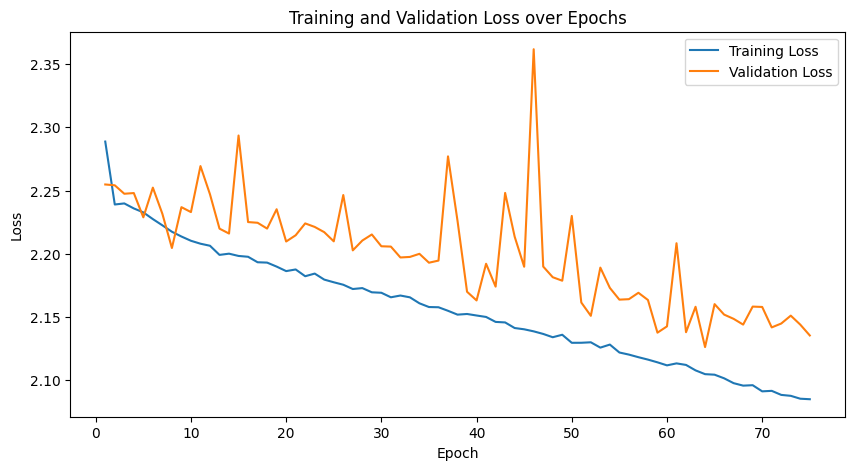

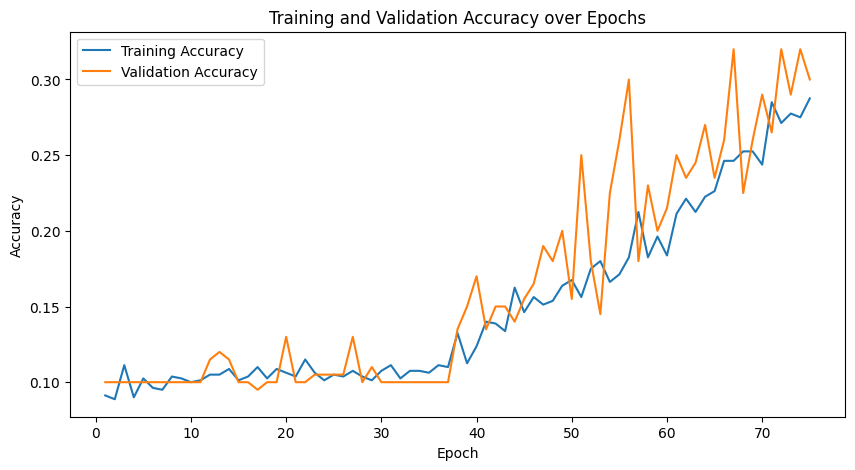

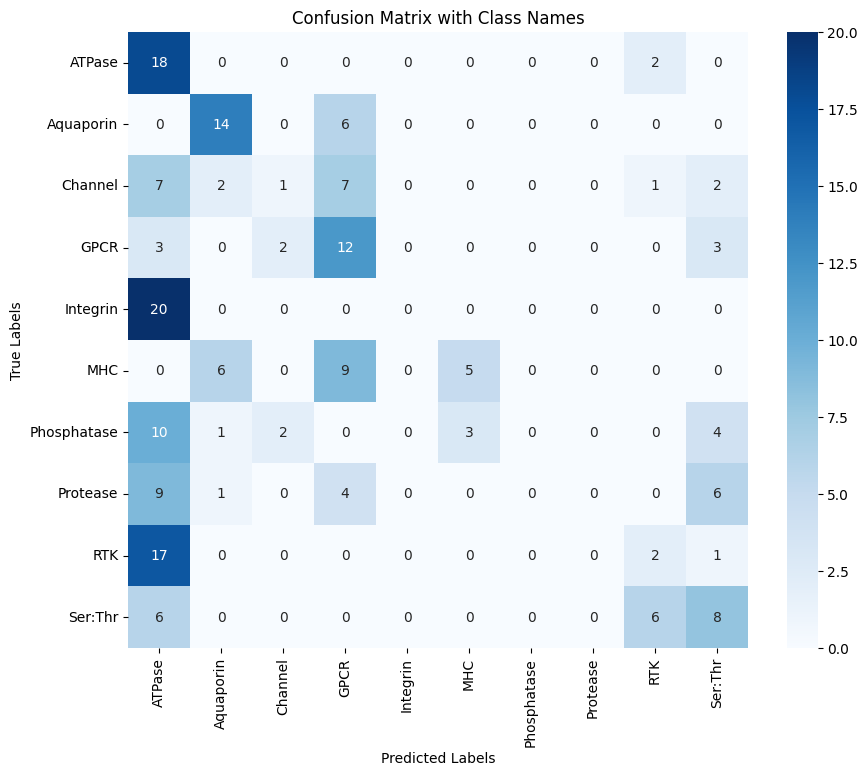

In [ ]:
### Running the Neural Network ###

num_epochs = 75
val_best = 0.0
patience = 15
epochs_without_improvement = 0

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Collect predictions and labels for accuracy calculation
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Compute average loss and accuracy over the epoch
    avg_loss = running_loss / len(train_loader)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')

    # Validation Step
    model.eval()
    val_running_loss = 0.0
    val_all_labels = []
    val_all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_all_labels.extend(labels.cpu().numpy())
            val_all_preds.extend(preds.cpu().numpy())

    val_loss = val_running_loss / len(test_loader)
    test_accuracy = accuracy_score(val_all_labels, val_all_preds)
    test_losses.append(val_loss)
    test_accuracies.append(test_accuracy)

    print(f'Test Loss: {val_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    """# Early stopping
    if test_accuracy > val_best:
        val_best = test_accuracy
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
"""
# Plot training and validation loss over epochs
plt.figure(figsize=(10,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses)+1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Plot training and validation accuracy over epochs
plt.figure(figsize=(10,5))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Convert predictions and true labels back to class names
y_test_labels = label_encoder.inverse_transform(val_all_labels)
test_preds_labels = label_encoder.inverse_transform(val_all_preds)

# Generate confusion matrix and plot
conf_matrix = confusion_matrix(y_test_labels, test_preds_labels, labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Class Names')
plt.show()

In [ ]:
print(df_RNN.head())

    Entry                                           Sequence ProteinClass
0  P07151  MARSVTVIFLVLVSLAVVLAIQKTPQIQVYSRHPPENGKPNFLNCY...          MHC
1  P78325  MRGLGLWLLGAMMLPAIAPSRPWALMEQYEVVLPWRLPGPRVRRAL...     Protease
2  Q16819  MAWIRSTCILFFTLLFAHIAAVPIKYLPEENVHDADFGEQKDISEI...     Protease
3  Q92932  MGPPLPLLLLLLLLLPPRVLPAAPSSVPRGRQLPGRLGCLLEEGLC...  Phosphatase
4  Q3UV74  MLGQCTLLPVLAGLLSLESALSQLCTKDNVSTCQDCIRSGPSCAWC...     Integrin


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 729ms/step - accuracy: 0.0919 - loss: 2.3601 - val_accuracy: 0.0650 - val_loss: 2.3611
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 684ms/step - accuracy: 0.0873 - loss: 2.3609 - val_accuracy: 0.0700 - val_loss: 2.3332
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 686ms/step - accuracy: 0.1163 - loss: 2.3254 - val_accuracy: 0.0650 - val_loss: 2.3535
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 688ms/step - accuracy: 0.1037 - loss: 2.3286 - val_accuracy: 0.1250 - val_loss: 2.3247
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 688ms/step - accuracy: 0.0926 - loss: 2.3347 - val_accuracy: 0.0850 - val_loss: 2.3424
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 698ms/step - accuracy: 0.0878 - loss: 2.3519 - val_accuracy: 0.1000 - val_loss: 2.3784
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 685ms/step - accuracy: 0.0982 - loss: 2.3865 - val_accuracy: 0.0800 - val_loss: 2.4267
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 678ms/step - accuracy: 0.1081 - loss: 2.3932 - val_accuracy: 0.110

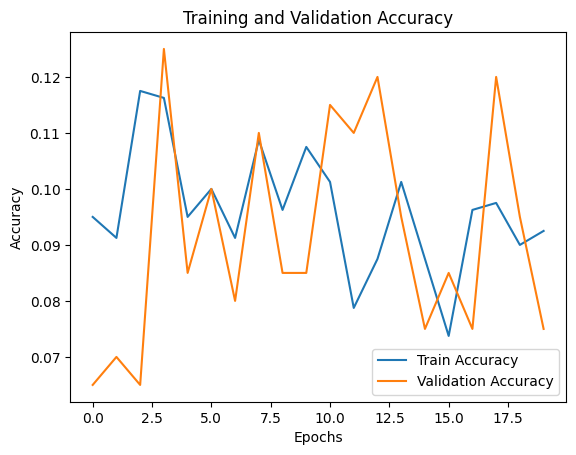

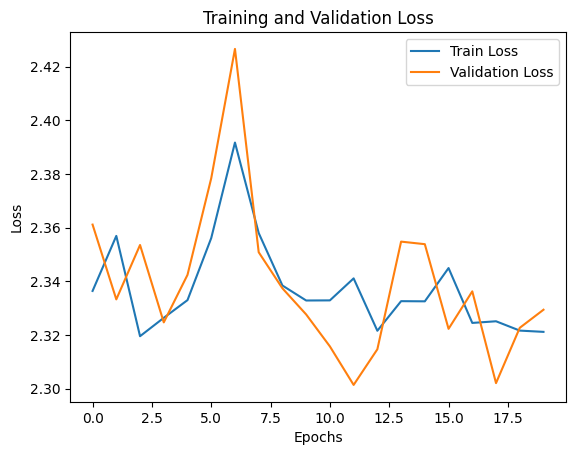

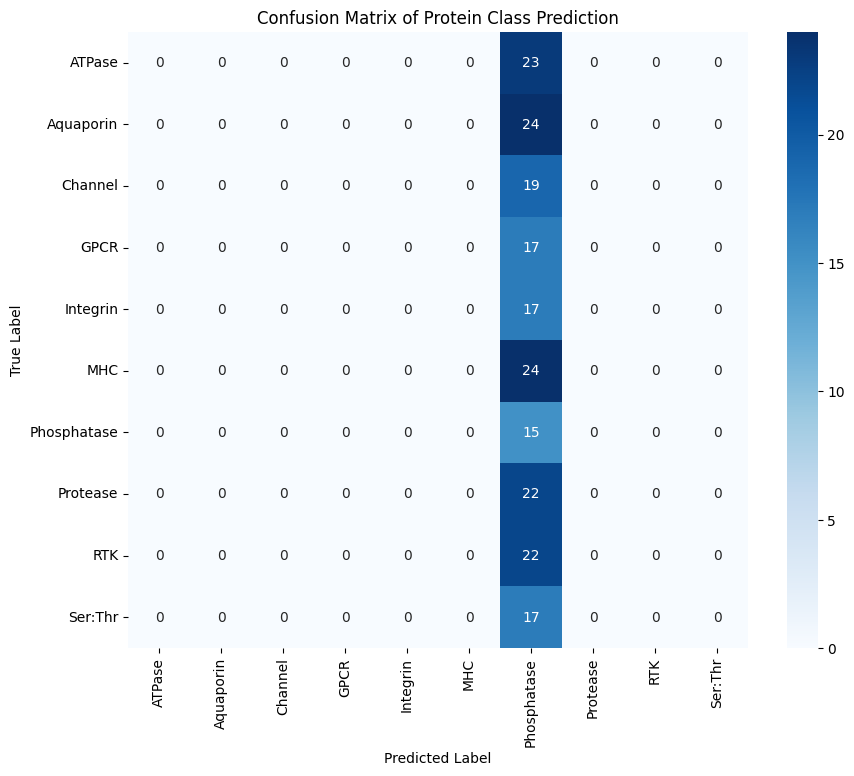

Classification Report
              precision    recall  f1-score   support

      ATPase       0.00      0.00      0.00        23
   Aquaporin       0.00      0.00      0.00        24
     Channel       0.00      0.00      0.00        19
        GPCR       0.00      0.00      0.00        17
    Integrin       0.00      0.00      0.00        17
         MHC       0.00      0.00      0.00        24
 Phosphatase       0.07      1.00      0.14        15
    Protease       0.00      0.00      0.00        22
         RTK       0.00      0.00      0.00        22
     Ser:Thr       0.00      0.00      0.00        17

    accuracy                           0.07       200
   macro avg       0.01      0.10      0.01       200
weighted avg       0.01      0.07      0.01       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Using an RNN

# Tokenization
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(df_RNN['Sequence'])
sequences = tokenizer.texts_to_sequences(df_RNN['Sequence'])

# Padding the sequences
max_seq_length = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

# Encode protein class labels to compare to output nodes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_RNN['ProteinClass'])
y = tf.keras.utils.to_categorical(y, num_classes=len(label_encoder.classes_))

# Split the data for training vs. testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Build the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=max_seq_length))
# model.add(Masking(mask_value=0.0, input_shape=(max_seq_length,)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the Model
optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Print Model Evaluation Statistics
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Predict classes for the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Convert y_test to multiclass format
y_test_multiclass = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_multiclass, y_pred)

# Get class labels
class_names = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Protein Class Prediction')
plt.show()

# Print classification report
print('Classification Report')
print(classification_report(y_test_multiclass, y_pred, target_names=class_names))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 920ms/step - accuracy: 0.0923 - loss: 2.3046 - val_accuracy: 0.0840 - val_loss: 2.3037
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 818ms/step - accuracy: 0.0972 - loss: 2.3054 - val_accuracy: 0.0840 - val_loss: 2.3042
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 823ms/step - accuracy: 0.1065 - loss: 2.3028 - val_accuracy: 0.0840 - val_loss: 2.3049
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 827ms/step - accuracy: 0.1101 - loss: nan - val_accuracy: 0.0920 - val_loss: nan
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 818ms/step - accuracy: 0.1115 - loss: nan - val_accuracy: 0.0920 - val_loss: nan
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 824ms/step - accuracy: 0.1155 - loss: nan - val_accuracy: 0.0920 - val_loss: nan
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 818ms/step - accuracy: 0.1039 - loss: nan - val_accuracy: 0.0920 - val_loss: nan
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 825ms/step - accuracy: 0.1035 - loss: nan - val_accuracy: 0.0920 - val_loss: nan
Epoch 9/2

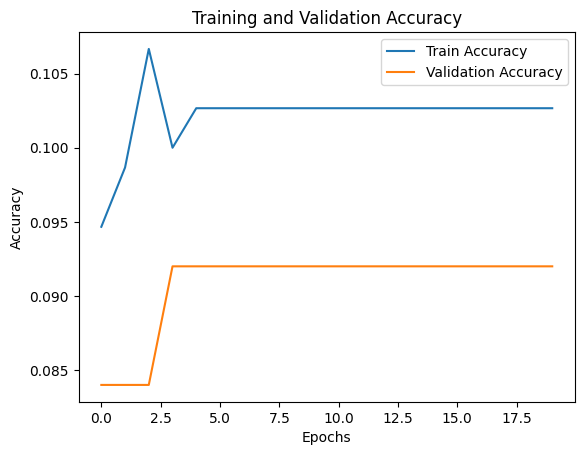

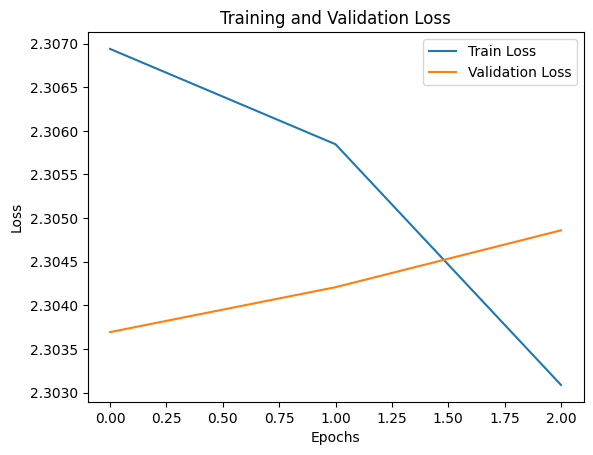

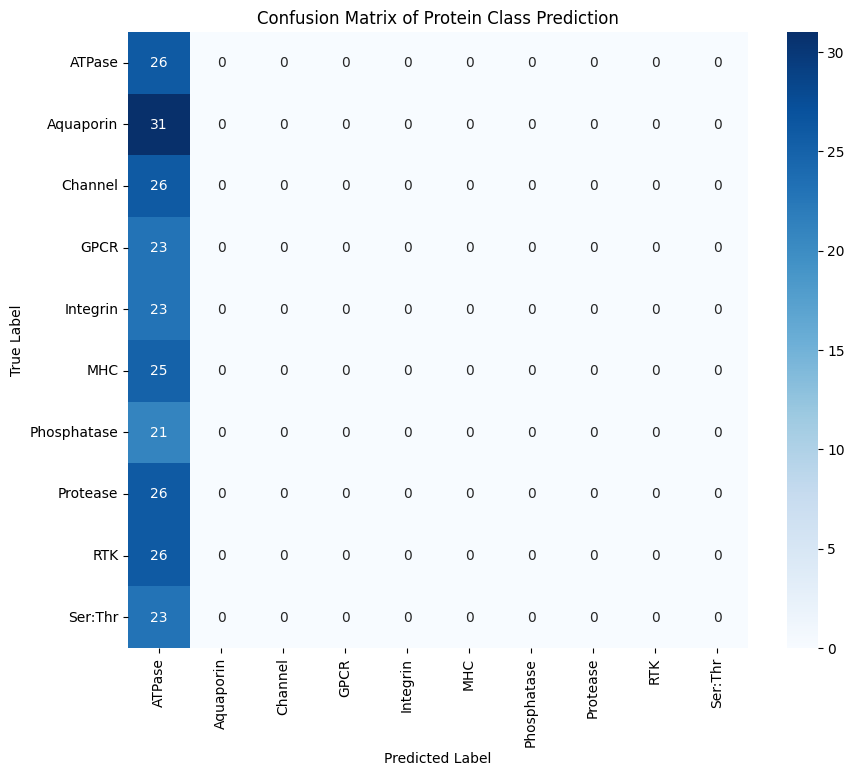

Classification Report
              precision    recall  f1-score   support

      ATPase       0.10      1.00      0.19        26
   Aquaporin       0.00      0.00      0.00        31
     Channel       0.00      0.00      0.00        26
        GPCR       0.00      0.00      0.00        23
    Integrin       0.00      0.00      0.00        23
         MHC       0.00      0.00      0.00        25
 Phosphatase       0.00      0.00      0.00        21
    Protease       0.00      0.00      0.00        26
         RTK       0.00      0.00      0.00        26
     Ser:Thr       0.00      0.00      0.00        23

    accuracy                           0.10       250
   macro avg       0.01      0.10      0.02       250
weighted avg       0.01      0.10      0.02       250



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Using an LSTM

# Tokenization
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(df_RNN['Sequence'])
sequences = tokenizer.texts_to_sequences(df_RNN['Sequence'])

# Padding the sequences
max_seq_length = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

# Encode protein class labels to compare to output nodes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_RNN['ProteinClass'])
y = tf.keras.utils.to_categorical(y, num_classes=len(label_encoder.classes_))

# Split the data for training vs. testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Build the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=max_seq_length))
# model.add(Masking(mask_value=0.0, input_shape=(max_seq_length,)))
model.add(LSTM(units=64, activation='relu', recurrent_activation='hard_sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the Model
optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Print Model Evaluation Statistics
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Predict classes for the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Convert y_test to multiclass format
y_test_multiclass = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_multiclass, y_pred)

# Get class labels
class_names = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Protein Class Prediction')
plt.show()

# Print classification report
print('Classification Report')
print(classification_report(y_test_multiclass, y_pred, target_names=class_names))